# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Discrete)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with synthetic Real-Time Bidding (RTB) dataset.

Our example with Synthetic RTB Simualtion and Dataset contains the following 5 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate, Distributionally Robust Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import offlinegym modules
import offlinegym
from rtbgym import RTBEnv, CustomizedRTBEnv
from offlinegym.dataset import SyntheticDataset
from offlinegym.policy import OnlineHead
from offlinegym.policy import DiscreteEpsilonGreedyHead as EpsilonGreedyHead
from offlinegym.policy import DiscreteSoftmaxHead as SoftmaxHead
from offlinegym.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(offlinegym.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the RTB environment works for the preparation.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (such as numbers of click or conversion) within a episode under the given budget constraints.  
We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we adjust bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe statistical feedback from environment at each timestep, which include following informations.
  - timestep
  - remaining budget
  - impression level features (budget comsuption rate, cost per mille of impressions, auction winning rate, reward) at previous timestep
  - adjust rate (RL agent's decision making) at previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

For more about the environmental configuration and its customization, please refer to [examples/quickstart/rtb_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_customize_env.ipynb).

In [9]:
# setup environment
env = RTBEnv(random_state=random_state)

In [10]:
# customize the environment and discretize action space
env = CustomizedRTBEnv(
    original_env=env,
    reward_predictor=LogisticRegression(),
    action_type="discrete",
)

#### Synthetic Data Generation
Next, we collect logged data with the uniform random agent.

We have following arguments for `SyntheticDataset` class:
- `env`: RTB environment for RL defined in the previous section.
- `bahavior_policy`: RL agent (or algorithm) used for the data collection.
- `n_samples_pretrain_reward_predictor`: Numbers of samples used to pretrain reward predictor.

For more about the data collection and visualization, please refer to [examples/quickstart/rtb_synthetic_data_collection.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [17]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
)

2022-04-14 11:05.56 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20220414110556
2022-04-14 11:05.56 [debug    ] Building model...
2022-04-14 11:05.56 [debug    ] Model has been built.
2022-04-14 11:05.56 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_reduction_type': 'min', 'target_update_interval': 100, 'use_gpu': None, 'algorithm

  1%|          | 980/100000 [00:02<03:34, 462.17it/s]

2022-04-14 11:05.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_1000.pt
2022-04-14 11:05.59 [info     ] DoubleDQN_online_20220414110556: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00033011794090270996, 'time_environment_step': 0.0006238847460065569, 'time_step': 0.0022564518451690676, 'rollout_return': 9.72, 'time_sample_batch': 7.691512102897541e-05, 'time_algorithm_update': 0.0012986682285772305, 'loss': 99.25862099497984, 'evaluation': 0.0} step=1000


  2%|▏         | 1995/100000 [00:04<03:28, 469.23it/s]

2022-04-14 11:06.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_2000.pt
2022-04-14 11:06.01 [info     ] DoubleDQN_online_20220414110556: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00028951382637023925, 'time_environment_step': 0.000577282224382673, 'time_sample_batch': 7.201576232910156e-05, 'time_algorithm_update': 0.0011991865634918212, 'loss': 23.890702256917955, 'time_step': 0.002117462635040283, 'rollout_return': 1.728, 'evaluation': 0.0} step=2000


  3%|▎         | 2998/100000 [00:06<03:23, 476.16it/s]

2022-04-14 11:06.03 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_3000.pt
2022-04-14 11:06.03 [info     ] DoubleDQN_online_20220414110556: epoch=3 step=3000 epoch=3 metrics={'time_inference': 0.0002948753833770752, 'time_environment_step': 0.0005870884486607143, 'time_sample_batch': 7.476472854614258e-05, 'time_algorithm_update': 0.001230006217956543, 'loss': 19.173000716984273, 'time_step': 0.0021654915809631347, 'rollout_return': 2.08, 'evaluation': 0.0} step=3000


  4%|▍         | 3961/100000 [00:09<03:31, 453.55it/s]

2022-04-14 11:06.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_4000.pt
2022-04-14 11:06.06 [info     ] DoubleDQN_online_20220414110556: epoch=4 step=4000 epoch=4 metrics={'time_inference': 0.0003010022640228271, 'time_environment_step': 0.0006079183306012835, 'time_sample_batch': 7.909321784973144e-05, 'time_algorithm_update': 0.0012498505115509032, 'loss': 17.13212340372801, 'time_step': 0.002216491222381592, 'rollout_return': 1.576, 'evaluation': 0.0} step=4000


  5%|▍         | 4957/100000 [00:11<03:21, 472.13it/s]

2022-04-14 11:06.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_5000.pt
2022-04-14 11:06.08 [info     ] DoubleDQN_online_20220414110556: epoch=5 step=5000 epoch=5 metrics={'time_inference': 0.00028872299194335937, 'time_environment_step': 0.000578160149710519, 'time_sample_batch': 7.566022872924804e-05, 'time_algorithm_update': 0.00119366455078125, 'loss': 15.824087971687318, 'time_step': 0.0021158168315887453, 'rollout_return': 1.712, 'evaluation': 0.0} step=5000


  6%|▌         | 5957/100000 [00:13<03:17, 477.32it/s]

2022-04-14 11:06.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_6000.pt
2022-04-14 11:06.10 [info     ] DoubleDQN_online_20220414110556: epoch=6 step=6000 epoch=6 metrics={'time_inference': 0.00027510738372802735, 'time_environment_step': 0.0005491493770054408, 'time_sample_batch': 7.05409049987793e-05, 'time_algorithm_update': 0.0011442084312438966, 'loss': 14.319685617506504, 'time_step': 0.0020193214416503904, 'rollout_return': 1.968, 'evaluation': 0.0} step=6000


  7%|▋         | 6972/100000 [00:15<03:14, 479.24it/s]

2022-04-14 11:06.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_7000.pt
2022-04-14 11:06.12 [info     ] DoubleDQN_online_20220414110556: epoch=7 step=7000 epoch=7 metrics={'time_inference': 0.0002868475914001465, 'time_environment_step': 0.0005730618068150112, 'time_sample_batch': 7.494068145751953e-05, 'time_algorithm_update': 0.0012023401260375976, 'loss': 12.71053764052689, 'time_step': 0.0021166162490844726, 'rollout_return': 2.128, 'evaluation': 0.0} step=7000


  8%|▊         | 7972/100000 [00:17<03:16, 468.48it/s]

2022-04-14 11:06.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_8000.pt
2022-04-14 11:06.14 [info     ] DoubleDQN_online_20220414110556: epoch=8 step=8000 epoch=8 metrics={'time_inference': 0.0002917468547821045, 'time_environment_step': 0.00059002685546875, 'time_sample_batch': 7.624125480651855e-05, 'time_algorithm_update': 0.0012129395008087158, 'loss': 11.314554485201835, 'time_step': 0.00214982795715332, 'rollout_return': 2.048, 'evaluation': 0.5} step=8000


  9%|▉         | 8974/100000 [00:20<03:06, 487.73it/s]

2022-04-14 11:06.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_9000.pt
2022-04-14 11:06.17 [info     ] DoubleDQN_online_20220414110556: epoch=9 step=9000 epoch=9 metrics={'time_inference': 0.0002867851257324219, 'time_environment_step': 0.0005743340083530971, 'time_sample_batch': 7.454752922058106e-05, 'time_algorithm_update': 0.0011971933841705322, 'loss': 9.901137651845813, 'time_step': 0.002112317323684692, 'rollout_return': 2.016, 'evaluation': 0.0} step=9000


 10%|▉         | 9981/100000 [00:22<03:10, 471.39it/s]

2022-04-14 11:06.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_10000.pt
2022-04-14 11:06.19 [info     ] DoubleDQN_online_20220414110556: epoch=10 step=10000 epoch=10 metrics={'time_inference': 0.00028729629516601563, 'time_environment_step': 0.0005802715846470424, 'time_sample_batch': 7.590913772583008e-05, 'time_algorithm_update': 0.00120102858543396, 'loss': 8.800295424848795, 'time_step': 0.002124072790145874, 'rollout_return': 1.832, 'evaluation': 0.1} step=10000


 11%|█         | 10998/100000 [00:24<03:03, 486.26it/s]

2022-04-14 11:06.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_11000.pt
2022-04-14 11:06.21 [info     ] DoubleDQN_online_20220414110556: epoch=11 step=11000 epoch=11 metrics={'time_inference': 0.0002883741855621338, 'time_environment_step': 0.0005779735020228795, 'time_sample_batch': 7.558274269104004e-05, 'time_algorithm_update': 0.0011953561305999756, 'loss': 7.6812915018498895, 'time_step': 0.0021162681579589846, 'rollout_return': 1.576, 'evaluation': 0.5} step=11000


 12%|█▏        | 11988/100000 [00:26<03:04, 478.27it/s]

2022-04-14 11:06.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_12000.pt
2022-04-14 11:06.23 [info     ] DoubleDQN_online_20220414110556: epoch=12 step=12000 epoch=12 metrics={'time_inference': 0.0002784421443939209, 'time_environment_step': 0.000554931640625, 'time_sample_batch': 7.279109954833984e-05, 'time_algorithm_update': 0.0011564095020294189, 'loss': 6.484065993338823, 'time_step': 0.0020431690216064454, 'rollout_return': 3.336, 'evaluation': 0.0} step=12000


 13%|█▎        | 12979/100000 [00:29<03:07, 465.16it/s]

2022-04-14 11:06.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_13000.pt
2022-04-14 11:06.26 [info     ] DoubleDQN_online_20220414110556: epoch=13 step=13000 epoch=13 metrics={'time_inference': 0.0002974357604980469, 'time_environment_step': 0.0006022502354213169, 'time_sample_batch': 7.852387428283692e-05, 'time_algorithm_update': 0.0012460672855377198, 'loss': 5.573769731760025, 'time_step': 0.0022037353515625, 'rollout_return': 4.2, 'evaluation': 4.2} step=13000


 14%|█▍        | 13983/100000 [00:31<03:03, 469.73it/s]

2022-04-14 11:06.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_14000.pt
2022-04-14 11:06.28 [info     ] DoubleDQN_online_20220414110556: epoch=14 step=14000 epoch=14 metrics={'time_inference': 0.00028640365600585935, 'time_environment_step': 0.000574362073625837, 'time_sample_batch': 7.551813125610351e-05, 'time_algorithm_update': 0.001199239492416382, 'loss': 4.729541130721569, 'time_step': 0.002116283893585205, 'rollout_return': 2.48, 'evaluation': 0.0} step=14000


 15%|█▍        | 14960/100000 [00:33<02:55, 485.16it/s]

2022-04-14 11:06.30 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_15000.pt
2022-04-14 11:06.30 [info     ] DoubleDQN_online_20220414110556: epoch=15 step=15000 epoch=15 metrics={'time_inference': 0.0002799358367919922, 'time_environment_step': 0.0005579632350376674, 'time_sample_batch': 7.304716110229492e-05, 'time_algorithm_update': 0.0011663377285003663, 'loss': 4.004485637307167, 'time_step': 0.0020587053298950194, 'rollout_return': 2.808, 'evaluation': 0.0} step=15000


 16%|█▌        | 15998/100000 [00:35<03:02, 460.04it/s]

2022-04-14 11:06.32 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_16000.pt
2022-04-14 11:06.32 [info     ] DoubleDQN_online_20220414110556: epoch=16 step=16000 epoch=16 metrics={'time_inference': 0.000292696475982666, 'time_environment_step': 0.000596597671508789, 'time_sample_batch': 7.829523086547852e-05, 'time_algorithm_update': 0.001227421760559082, 'loss': 3.360854852646589, 'time_step': 0.0021760156154632566, 'rollout_return': 3.88, 'evaluation': 1.1} step=16000


 17%|█▋        | 16987/100000 [00:38<02:53, 478.68it/s]

2022-04-14 11:06.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_17000.pt
2022-04-14 11:06.35 [info     ] DoubleDQN_online_20220414110556: epoch=17 step=17000 epoch=17 metrics={'time_inference': 0.00029302287101745607, 'time_environment_step': 0.0005863900865827288, 'time_sample_batch': 7.752561569213867e-05, 'time_algorithm_update': 0.0012237076759338379, 'loss': 2.734094562396407, 'time_step': 0.0021609747409820556, 'rollout_return': 5.216, 'evaluation': 15.6} step=17000


 18%|█▊        | 17965/100000 [00:40<02:48, 487.52it/s]

2022-04-14 11:06.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_18000.pt
2022-04-14 11:06.37 [info     ] DoubleDQN_online_20220414110556: epoch=18 step=18000 epoch=18 metrics={'time_inference': 0.0002772555351257324, 'time_environment_step': 0.0005586599622453962, 'time_sample_batch': 7.318711280822754e-05, 'time_algorithm_update': 0.0011604804992675782, 'loss': 2.499227356135845, 'time_step': 0.0020506067276000977, 'rollout_return': 5.984, 'evaluation': 6.2} step=18000


 19%|█▉        | 18990/100000 [00:42<03:00, 449.18it/s]

2022-04-14 11:06.39 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_19000.pt
2022-04-14 11:06.39 [info     ] DoubleDQN_online_20220414110556: epoch=19 step=19000 epoch=19 metrics={'time_inference': 0.0002932326793670654, 'time_environment_step': 0.000592822756086077, 'time_sample_batch': 7.83076286315918e-05, 'time_algorithm_update': 0.0012332556247711182, 'loss': 2.063758969761431, 'time_step': 0.0021778478622436525, 'rollout_return': 11.224, 'evaluation': 14.6} step=19000


 20%|█▉        | 19983/100000 [00:44<03:05, 430.95it/s]

2022-04-14 11:06.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_20000.pt
2022-04-14 11:06.41 [info     ] DoubleDQN_online_20220414110556: epoch=20 step=20000 epoch=20 metrics={'time_inference': 0.00030390167236328124, 'time_environment_step': 0.0006171422685895648, 'time_sample_batch': 8.142542839050294e-05, 'time_algorithm_update': 0.0012716338634490966, 'loss': 1.8468048789650202, 'time_step': 0.002253688097000122, 'rollout_return': 12.528, 'evaluation': 15.0} step=20000


 21%|██        | 20956/100000 [00:47<02:55, 450.54it/s]

2022-04-14 11:06.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_21000.pt
2022-04-14 11:06.44 [info     ] DoubleDQN_online_20220414110556: epoch=21 step=21000 epoch=21 metrics={'time_inference': 0.00030862236022949216, 'time_environment_step': 0.0006229997362409319, 'time_sample_batch': 8.130860328674317e-05, 'time_algorithm_update': 0.001288137912750244, 'loss': 1.7693799377828836, 'time_step': 0.0022800776958465576, 'rollout_return': 12.504, 'evaluation': 15.8} step=21000


 22%|██▏       | 21987/100000 [00:49<02:42, 480.85it/s]

2022-04-14 11:06.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_22000.pt
2022-04-14 11:06.46 [info     ] DoubleDQN_online_20220414110556: epoch=22 step=22000 epoch=22 metrics={'time_inference': 0.00027803897857666017, 'time_environment_step': 0.0005535493578229632, 'time_sample_batch': 7.227444648742676e-05, 'time_algorithm_update': 0.0011577367782592773, 'loss': 1.7418417991697788, 'time_step': 0.002042864799499512, 'rollout_return': 11.848, 'evaluation': 10.9} step=22000


 23%|██▎       | 22979/100000 [00:51<02:42, 475.30it/s]

2022-04-14 11:06.48 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_23000.pt
2022-04-14 11:06.48 [info     ] DoubleDQN_online_20220414110556: epoch=23 step=23000 epoch=23 metrics={'time_inference': 0.0002906167507171631, 'time_environment_step': 0.0005844056265694754, 'time_sample_batch': 7.665085792541504e-05, 'time_algorithm_update': 0.001211081027984619, 'loss': 1.518766132235527, 'time_step': 0.0021434404850006103, 'rollout_return': 13.144, 'evaluation': 0.0} step=23000


 24%|██▍       | 23995/100000 [00:53<02:37, 481.36it/s]

2022-04-14 11:06.50 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_24000.pt
2022-04-14 11:06.50 [info     ] DoubleDQN_online_20220414110556: epoch=24 step=24000 epoch=24 metrics={'time_inference': 0.000283228874206543, 'time_environment_step': 0.0005629915509905134, 'time_sample_batch': 7.342863082885743e-05, 'time_algorithm_update': 0.0011764347553253173, 'loss': 1.5508852027654647, 'time_step': 0.0020769274234771727, 'rollout_return': 12.576, 'evaluation': 15.2} step=24000


 25%|██▍       | 24971/100000 [00:55<02:35, 482.57it/s]

2022-04-14 11:06.52 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_25000.pt
2022-04-14 11:06.53 [info     ] DoubleDQN_online_20220414110556: epoch=25 step=25000 epoch=25 metrics={'time_inference': 0.0002814624309539795, 'time_environment_step': 0.0005610863821847098, 'time_sample_batch': 7.367134094238281e-05, 'time_algorithm_update': 0.0011729300022125244, 'loss': 1.4265357282459736, 'time_step': 0.002070167303085327, 'rollout_return': 13.432, 'evaluation': 15.5} step=25000


 26%|██▌       | 25989/100000 [00:58<02:35, 476.28it/s]

2022-04-14 11:06.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_26000.pt
2022-04-14 11:06.55 [info     ] DoubleDQN_online_20220414110556: epoch=26 step=26000 epoch=26 metrics={'time_inference': 0.00028348708152770995, 'time_environment_step': 0.000561344964163644, 'time_sample_batch': 7.328939437866212e-05, 'time_algorithm_update': 0.0011888818740844727, 'loss': 1.3196641362905501, 'time_step': 0.0020881736278533934, 'rollout_return': 12.76, 'evaluation': 11.5} step=26000


 27%|██▋       | 26979/100000 [01:00<02:53, 421.62it/s]

2022-04-14 11:06.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_27000.pt
2022-04-14 11:06.57 [info     ] DoubleDQN_online_20220414110556: epoch=27 step=27000 epoch=27 metrics={'time_inference': 0.00031086373329162597, 'time_environment_step': 0.0006163169315883091, 'time_sample_batch': 8.162641525268554e-05, 'time_algorithm_update': 0.0012830445766448975, 'loss': 1.275830501407385, 'time_step': 0.0022719945907592773, 'rollout_return': 13.832, 'evaluation': 2.5} step=27000


 28%|██▊       | 27994/100000 [01:02<02:28, 483.41it/s]

2022-04-14 11:06.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_28000.pt
2022-04-14 11:06.59 [info     ] DoubleDQN_online_20220414110556: epoch=28 step=28000 epoch=28 metrics={'time_inference': 0.00028546142578125, 'time_environment_step': 0.0005595700400216238, 'time_sample_batch': 7.353091239929199e-05, 'time_algorithm_update': 0.0011763014793395995, 'loss': 1.2251580253839494, 'time_step': 0.0020766630172729494, 'rollout_return': 12.824, 'evaluation': 11.2} step=28000


 29%|██▉       | 28954/100000 [01:04<02:30, 473.15it/s]

2022-04-14 11:07.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_29000.pt
2022-04-14 11:07.02 [info     ] DoubleDQN_online_20220414110556: epoch=29 step=29000 epoch=29 metrics={'time_inference': 0.00028890681266784666, 'time_environment_step': 0.0005776623317173549, 'time_sample_batch': 7.540225982666015e-05, 'time_algorithm_update': 0.001203765869140625, 'loss': 1.1220088296830655, 'time_step': 0.002126081466674805, 'rollout_return': 13.344, 'evaluation': 13.5} step=29000


 30%|██▉       | 29961/100000 [01:07<02:30, 466.18it/s]

2022-04-14 11:07.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_30000.pt
2022-04-14 11:07.04 [info     ] DoubleDQN_online_20220414110556: epoch=30 step=30000 epoch=30 metrics={'time_inference': 0.0002857794761657715, 'time_environment_step': 0.0005726912362234933, 'time_sample_batch': 7.509112358093261e-05, 'time_algorithm_update': 0.0011900267601013183, 'loss': 0.9958939555734396, 'time_step': 0.0021039361953735353, 'rollout_return': 14.208, 'evaluation': 0.0} step=30000


 31%|███       | 30960/100000 [01:09<02:25, 475.50it/s]

2022-04-14 11:07.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_31000.pt
2022-04-14 11:07.06 [info     ] DoubleDQN_online_20220414110556: epoch=31 step=31000 epoch=31 metrics={'time_inference': 0.0002895047664642334, 'time_environment_step': 0.0005712536403111049, 'time_sample_batch': 7.489466667175292e-05, 'time_algorithm_update': 0.0011989943981170655, 'loss': 1.0355139551609756, 'time_step': 0.0021157848834991457, 'rollout_return': 12.896, 'evaluation': 17.6} step=31000


 32%|███▏      | 31960/100000 [01:11<02:24, 469.26it/s]

2022-04-14 11:07.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_32000.pt
2022-04-14 11:07.08 [info     ] DoubleDQN_online_20220414110556: epoch=32 step=32000 epoch=32 metrics={'time_inference': 0.0002921268939971924, 'time_environment_step': 0.0005808585030691964, 'time_sample_batch': 7.669258117675782e-05, 'time_algorithm_update': 0.0012214870452880858, 'loss': 0.9800485378652811, 'time_step': 0.0021518614292144775, 'rollout_return': 13.088, 'evaluation': 15.1} step=32000


 33%|███▎      | 32982/100000 [01:13<02:18, 482.59it/s]

2022-04-14 11:07.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_33000.pt
2022-04-14 11:07.10 [info     ] DoubleDQN_online_20220414110556: epoch=33 step=33000 epoch=33 metrics={'time_inference': 0.0002799324989318848, 'time_environment_step': 0.0005584553309849331, 'time_sample_batch': 7.328534126281738e-05, 'time_algorithm_update': 0.0011682684421539307, 'loss': 0.9685099849700928, 'time_step': 0.002061314344406128, 'rollout_return': 14.384, 'evaluation': 15.8} step=33000


 34%|███▍      | 33986/100000 [01:16<02:20, 468.51it/s]

2022-04-14 11:07.13 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_34000.pt
2022-04-14 11:07.13 [info     ] DoubleDQN_online_20220414110556: epoch=34 step=34000 epoch=34 metrics={'time_inference': 0.00028806304931640623, 'time_environment_step': 0.0005731299264090402, 'time_sample_batch': 7.537293434143066e-05, 'time_algorithm_update': 0.0011968390941619873, 'loss': 0.969199785888195, 'time_step': 0.002114600419998169, 'rollout_return': 14.224, 'evaluation': 14.1} step=34000


 35%|███▍      | 34990/100000 [01:18<02:15, 480.91it/s]

2022-04-14 11:07.15 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_35000.pt
2022-04-14 11:07.15 [info     ] DoubleDQN_online_20220414110556: epoch=35 step=35000 epoch=35 metrics={'time_inference': 0.0002864983081817627, 'time_environment_step': 0.0005731492723737444, 'time_sample_batch': 7.51791000366211e-05, 'time_algorithm_update': 0.0012013075351715089, 'loss': 0.9854093354195357, 'time_step': 0.002117168664932251, 'rollout_return': 13.256, 'evaluation': 16.4} step=35000


 36%|███▌      | 35963/100000 [01:20<02:12, 484.35it/s]

2022-04-14 11:07.17 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_36000.pt
2022-04-14 11:07.17 [info     ] DoubleDQN_online_20220414110556: epoch=36 step=36000 epoch=36 metrics={'time_inference': 0.00028064894676208495, 'time_environment_step': 0.0005637675694056919, 'time_sample_batch': 7.444024085998536e-05, 'time_algorithm_update': 0.001178487539291382, 'loss': 0.9464325303733349, 'time_step': 0.002078343629837036, 'rollout_return': 15.496, 'evaluation': 14.7} step=36000


 37%|███▋      | 36991/100000 [01:22<02:11, 477.34it/s]

2022-04-14 11:07.19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_37000.pt
2022-04-14 11:07.19 [info     ] DoubleDQN_online_20220414110556: epoch=37 step=37000 epoch=37 metrics={'time_inference': 0.00029616093635559084, 'time_environment_step': 0.0005954905918666294, 'time_sample_batch': 7.756233215332031e-05, 'time_algorithm_update': 0.001229778289794922, 'loss': 0.918355963230133, 'time_step': 0.002178663969039917, 'rollout_return': 14.496, 'evaluation': 16.0} step=37000


 38%|███▊      | 37989/100000 [01:25<02:11, 473.23it/s]

2022-04-14 11:07.22 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_38000.pt
2022-04-14 11:07.22 [info     ] DoubleDQN_online_20220414110556: epoch=38 step=38000 epoch=38 metrics={'time_inference': 0.00028784847259521486, 'time_environment_step': 0.0005738912309919085, 'time_sample_batch': 7.610154151916504e-05, 'time_algorithm_update': 0.0012028207778930664, 'loss': 0.8789444563686848, 'time_step': 0.0021212432384490965, 'rollout_return': 15.408, 'evaluation': 14.8} step=38000


 39%|███▉      | 38952/100000 [01:27<02:08, 476.08it/s]

2022-04-14 11:07.24 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_39000.pt
2022-04-14 11:07.24 [info     ] DoubleDQN_online_20220414110556: epoch=39 step=39000 epoch=39 metrics={'time_inference': 0.0002839219570159912, 'time_environment_step': 0.0005685830797467913, 'time_sample_batch': 7.422113418579101e-05, 'time_algorithm_update': 0.0011988461017608642, 'loss': 0.8746930367201566, 'time_step': 0.0021062772274017334, 'rollout_return': 14.824, 'evaluation': 15.6} step=39000


 40%|███▉      | 39997/100000 [01:29<02:14, 447.16it/s]

2022-04-14 11:07.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_40000.pt
2022-04-14 11:07.26 [info     ] DoubleDQN_online_20220414110556: epoch=40 step=40000 epoch=40 metrics={'time_inference': 0.00029114079475402833, 'time_environment_step': 0.0005837584904261997, 'time_sample_batch': 7.641029357910156e-05, 'time_algorithm_update': 0.0012148618698120117, 'loss': 0.8641233427524566, 'time_step': 0.002146468162536621, 'rollout_return': 15.072, 'evaluation': 12.2} step=40000


 41%|████      | 40965/100000 [01:31<02:05, 471.44it/s]

2022-04-14 11:07.28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_41000.pt
2022-04-14 11:07.28 [info     ] DoubleDQN_online_20220414110556: epoch=41 step=41000 epoch=41 metrics={'time_inference': 0.0003010456562042236, 'time_environment_step': 0.0006010540553501674, 'time_sample_batch': 7.962203025817871e-05, 'time_algorithm_update': 0.0012550129890441894, 'loss': 0.8399112284183502, 'time_step': 0.002217003345489502, 'rollout_return': 15.016, 'evaluation': 15.8} step=41000


 42%|████▏     | 41990/100000 [01:34<02:00, 480.69it/s]

2022-04-14 11:07.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_42000.pt
2022-04-14 11:07.31 [info     ] DoubleDQN_online_20220414110556: epoch=42 step=42000 epoch=42 metrics={'time_inference': 0.00028078436851501463, 'time_environment_step': 0.0005591583251953125, 'time_sample_batch': 7.323288917541504e-05, 'time_algorithm_update': 0.001174405574798584, 'loss': 0.8317912482023239, 'time_step': 0.0020689449310302734, 'rollout_return': 14.92, 'evaluation': 16.8} step=42000


 43%|████▎     | 42982/100000 [01:36<02:16, 417.31it/s]

2022-04-14 11:07.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_43000.pt
2022-04-14 11:07.33 [info     ] DoubleDQN_online_20220414110556: epoch=43 step=43000 epoch=43 metrics={'time_inference': 0.00029947638511657715, 'time_environment_step': 0.000597247804914202, 'time_sample_batch': 7.888102531433105e-05, 'time_algorithm_update': 0.0012438819408416748, 'loss': 0.8401055259108543, 'time_step': 0.002200469970703125, 'rollout_return': 13.648, 'evaluation': 16.1} step=43000


 44%|████▍     | 43989/100000 [01:38<01:58, 472.48it/s]

2022-04-14 11:07.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_44000.pt
2022-04-14 11:07.35 [info     ] DoubleDQN_online_20220414110556: epoch=44 step=44000 epoch=44 metrics={'time_inference': 0.00029946041107177735, 'time_environment_step': 0.000600567136492048, 'time_sample_batch': 7.899117469787597e-05, 'time_algorithm_update': 0.0012436447143554688, 'loss': 0.8249944960474968, 'time_step': 0.0022030465602874754, 'rollout_return': 14.28, 'evaluation': 14.9} step=44000


 45%|████▍     | 44984/100000 [01:40<01:59, 458.90it/s]

2022-04-14 11:07.37 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_45000.pt
2022-04-14 11:07.37 [info     ] DoubleDQN_online_20220414110556: epoch=45 step=45000 epoch=45 metrics={'time_inference': 0.00029135346412658694, 'time_environment_step': 0.0005815105438232422, 'time_sample_batch': 7.624006271362305e-05, 'time_algorithm_update': 0.001215054988861084, 'loss': 0.8201597503423691, 'time_step': 0.002144116401672363, 'rollout_return': 14.832, 'evaluation': 14.8} step=45000


 46%|████▌     | 45958/100000 [01:43<01:57, 458.96it/s]

2022-04-14 11:07.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_46000.pt
2022-04-14 11:07.40 [info     ] DoubleDQN_online_20220414110556: epoch=46 step=46000 epoch=46 metrics={'time_inference': 0.00028551316261291504, 'time_environment_step': 0.0005814375196184431, 'time_sample_batch': 7.474613189697265e-05, 'time_algorithm_update': 0.0011884174346923828, 'loss': 0.8275218902081252, 'time_step': 0.002109379291534424, 'rollout_return': 15.0, 'evaluation': 15.1} step=46000


 47%|████▋     | 46989/100000 [01:45<01:53, 465.55it/s]

2022-04-14 11:07.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_47000.pt
2022-04-14 11:07.42 [info     ] DoubleDQN_online_20220414110556: epoch=47 step=47000 epoch=47 metrics={'time_inference': 0.0002826945781707764, 'time_environment_step': 0.0005630683898925781, 'time_sample_batch': 7.390069961547851e-05, 'time_algorithm_update': 0.0011743512153625489, 'loss': 0.8077181592285633, 'time_step': 0.0020751969814300536, 'rollout_return': 14.552, 'evaluation': 13.2} step=47000


 48%|████▊     | 47993/100000 [01:47<01:49, 473.20it/s]

2022-04-14 11:07.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_48000.pt
2022-04-14 11:07.44 [info     ] DoubleDQN_online_20220414110556: epoch=48 step=48000 epoch=48 metrics={'time_inference': 0.00028683161735534667, 'time_environment_step': 0.0005762849535260882, 'time_sample_batch': 7.602500915527344e-05, 'time_algorithm_update': 0.001201096773147583, 'loss': 0.7993642402291298, 'time_step': 0.0021207733154296874, 'rollout_return': 14.416, 'evaluation': 16.4} step=48000


 49%|████▉     | 48969/100000 [01:49<01:44, 488.45it/s]

2022-04-14 11:07.46 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_49000.pt
2022-04-14 11:07.46 [info     ] DoubleDQN_online_20220414110556: epoch=49 step=49000 epoch=49 metrics={'time_inference': 0.0002806117534637451, 'time_environment_step': 0.0005583853040422712, 'time_sample_batch': 7.287263870239257e-05, 'time_algorithm_update': 0.0011673216819763183, 'loss': 0.840078576400876, 'time_step': 0.002060476064682007, 'rollout_return': 14.384, 'evaluation': 14.5} step=49000


 50%|████▉     | 49991/100000 [01:51<01:49, 455.81it/s]

2022-04-14 11:07.48 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_50000.pt
2022-04-14 11:07.48 [info     ] DoubleDQN_online_20220414110556: epoch=50 step=50000 epoch=50 metrics={'time_inference': 0.0002822153568267822, 'time_environment_step': 0.0005693672725132534, 'time_sample_batch': 7.421445846557618e-05, 'time_algorithm_update': 0.0011891694068908692, 'loss': 0.7627876716703177, 'time_step': 0.0020954046249389647, 'rollout_return': 14.136, 'evaluation': 15.8} step=50000


 51%|█████     | 50980/100000 [01:54<01:45, 466.06it/s]

2022-04-14 11:07.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_51000.pt
2022-04-14 11:07.51 [info     ] DoubleDQN_online_20220414110556: epoch=51 step=51000 epoch=51 metrics={'time_inference': 0.00028950858116149903, 'time_environment_step': 0.0005828383309500558, 'time_sample_batch': 7.625341415405273e-05, 'time_algorithm_update': 0.0012189433574676513, 'loss': 0.7792064163833856, 'time_step': 0.002147687911987305, 'rollout_return': 15.12, 'evaluation': 15.1} step=51000


 52%|█████▏    | 51996/100000 [01:56<01:38, 485.51it/s]

2022-04-14 11:07.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_52000.pt
2022-04-14 11:07.53 [info     ] DoubleDQN_online_20220414110556: epoch=52 step=52000 epoch=52 metrics={'time_inference': 0.00028144478797912596, 'time_environment_step': 0.0005696413857596261, 'time_sample_batch': 7.373738288879394e-05, 'time_algorithm_update': 0.0011811485290527343, 'loss': 0.7680323785990477, 'time_step': 0.0020865764617919924, 'rollout_return': 15.448, 'evaluation': 17.6} step=52000


 53%|█████▎    | 52966/100000 [01:58<01:43, 453.00it/s]

2022-04-14 11:07.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_53000.pt
2022-04-14 11:07.55 [info     ] DoubleDQN_online_20220414110556: epoch=53 step=53000 epoch=53 metrics={'time_inference': 0.00028292346000671385, 'time_environment_step': 0.0005671648297991071, 'time_sample_batch': 7.412433624267578e-05, 'time_algorithm_update': 0.0011880006790161133, 'loss': 0.7366009567975997, 'time_step': 0.002093020677566528, 'rollout_return': 15.192, 'evaluation': 17.4} step=53000


 54%|█████▍    | 53985/100000 [02:00<01:40, 460.02it/s]

2022-04-14 11:07.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_54000.pt
2022-04-14 11:07.57 [info     ] DoubleDQN_online_20220414110556: epoch=54 step=54000 epoch=54 metrics={'time_inference': 0.0002980945110321045, 'time_environment_step': 0.0005951314653669085, 'time_sample_batch': 7.846760749816895e-05, 'time_algorithm_update': 0.0012433154582977295, 'loss': 0.7727968493252992, 'time_step': 0.0021958527565002443, 'rollout_return': 14.304, 'evaluation': 10.4} step=54000


 55%|█████▍    | 54959/100000 [02:03<01:37, 461.73it/s]

2022-04-14 11:08.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_55000.pt
2022-04-14 11:08.00 [info     ] DoubleDQN_online_20220414110556: epoch=55 step=55000 epoch=55 metrics={'time_inference': 0.0002939343452453613, 'time_environment_step': 0.0005945211138044085, 'time_sample_batch': 7.847380638122558e-05, 'time_algorithm_update': 0.0012388994693756103, 'loss': 0.7490409522503615, 'time_step': 0.0021858856678009034, 'rollout_return': 15.056, 'evaluation': 15.6} step=55000


 56%|█████▌    | 55981/100000 [02:05<01:36, 455.26it/s]

2022-04-14 11:08.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_56000.pt
2022-04-14 11:08.02 [info     ] DoubleDQN_online_20220414110556: epoch=56 step=56000 epoch=56 metrics={'time_inference': 0.0003015365600585938, 'time_environment_step': 0.0006012744903564453, 'time_sample_batch': 7.876849174499512e-05, 'time_algorithm_update': 0.0012468175888061524, 'loss': 0.7590911337435245, 'time_step': 0.0022081613540649416, 'rollout_return': 14.816, 'evaluation': 15.5} step=56000


 57%|█████▋    | 56955/100000 [02:07<01:36, 447.88it/s]

2022-04-14 11:08.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_57000.pt
2022-04-14 11:08.04 [info     ] DoubleDQN_online_20220414110556: epoch=57 step=57000 epoch=57 metrics={'time_inference': 0.0002926387786865234, 'time_environment_step': 0.0005943456377301898, 'time_sample_batch': 7.82308578491211e-05, 'time_algorithm_update': 0.00123345947265625, 'loss': 0.7539053677171469, 'time_step': 0.002178478956222534, 'rollout_return': 14.168, 'evaluation': 17.1} step=57000


 58%|█████▊    | 57956/100000 [02:10<01:28, 476.99it/s]

2022-04-14 11:08.07 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_58000.pt
2022-04-14 11:08.07 [info     ] DoubleDQN_online_20220414110556: epoch=58 step=58000 epoch=58 metrics={'time_inference': 0.00028703880310058596, 'time_environment_step': 0.0005697784423828125, 'time_sample_batch': 7.387733459472656e-05, 'time_algorithm_update': 0.0011929962635040283, 'loss': 0.7629095773100854, 'time_step': 0.002103825092315674, 'rollout_return': 14.568, 'evaluation': 14.9} step=58000


 59%|█████▉    | 58969/100000 [02:12<01:34, 432.30it/s]

2022-04-14 11:08.09 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_59000.pt
2022-04-14 11:08.09 [info     ] DoubleDQN_online_20220414110556: epoch=59 step=59000 epoch=59 metrics={'time_inference': 0.0002894577980041504, 'time_environment_step': 0.0005772653307233537, 'time_sample_batch': 7.55305290222168e-05, 'time_algorithm_update': 0.0012080342769622803, 'loss': 0.7708111302554608, 'time_step': 0.0021310620307922364, 'rollout_return': 14.848, 'evaluation': 14.2} step=59000


 60%|█████▉    | 59974/100000 [02:14<01:22, 487.12it/s]

2022-04-14 11:08.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_60000.pt
2022-04-14 11:08.11 [info     ] DoubleDQN_online_20220414110556: epoch=60 step=60000 epoch=60 metrics={'time_inference': 0.00028529691696166994, 'time_environment_step': 0.0005645324162074498, 'time_sample_batch': 7.576894760131836e-05, 'time_algorithm_update': 0.0011854190826416015, 'loss': 0.7108097185492516, 'time_step': 0.002092102289199829, 'rollout_return': 15.056, 'evaluation': 16.4} step=60000


 61%|██████    | 60984/100000 [02:16<01:25, 458.12it/s]

2022-04-14 11:08.13 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_61000.pt
2022-04-14 11:08.13 [info     ] DoubleDQN_online_20220414110556: epoch=61 step=61000 epoch=61 metrics={'time_inference': 0.00028847169876098635, 'time_environment_step': 0.0005786525181361607, 'time_sample_batch': 7.582378387451172e-05, 'time_algorithm_update': 0.001216193675994873, 'loss': 0.7149311258941888, 'time_step': 0.0021397643089294434, 'rollout_return': 14.992, 'evaluation': 16.6} step=61000


 62%|██████▏   | 61989/100000 [02:19<01:22, 459.08it/s]

2022-04-14 11:08.16 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_62000.pt
2022-04-14 11:08.16 [info     ] DoubleDQN_online_20220414110556: epoch=62 step=62000 epoch=62 metrics={'time_inference': 0.00029898738861083987, 'time_environment_step': 0.0005990017482212611, 'time_sample_batch': 7.927918434143067e-05, 'time_algorithm_update': 0.001251737594604492, 'loss': 0.7408250099420548, 'time_step': 0.0022102353572845458, 'rollout_return': 14.904, 'evaluation': 11.5} step=62000


 63%|██████▎   | 62991/100000 [02:21<01:20, 458.42it/s]

2022-04-14 11:08.18 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_63000.pt
2022-04-14 11:08.18 [info     ] DoubleDQN_online_20220414110556: epoch=63 step=63000 epoch=63 metrics={'time_inference': 0.0002891993522644043, 'time_environment_step': 0.0005789470672607422, 'time_sample_batch': 7.609343528747558e-05, 'time_algorithm_update': 0.0012092130184173583, 'loss': 0.7237342879623174, 'time_step': 0.0021339309215545653, 'rollout_return': 14.672, 'evaluation': 13.6} step=63000


 64%|██████▍   | 63962/100000 [02:23<01:15, 477.10it/s]

2022-04-14 11:08.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_64000.pt
2022-04-14 11:08.20 [info     ] DoubleDQN_online_20220414110556: epoch=64 step=64000 epoch=64 metrics={'time_inference': 0.0002808470726013184, 'time_environment_step': 0.0005617975507463727, 'time_sample_batch': 7.305479049682617e-05, 'time_algorithm_update': 0.001174576997756958, 'loss': 0.7442328993976116, 'time_step': 0.0020710875988006593, 'rollout_return': 14.952, 'evaluation': 16.1} step=64000


 65%|██████▍   | 64975/100000 [02:25<01:14, 473.13it/s]

2022-04-14 11:08.22 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_65000.pt
2022-04-14 11:08.22 [info     ] DoubleDQN_online_20220414110556: epoch=65 step=65000 epoch=65 metrics={'time_inference': 0.0002830886840820312, 'time_environment_step': 0.0005660945347377232, 'time_sample_batch': 7.371020317077637e-05, 'time_algorithm_update': 0.0011843616962432862, 'loss': 0.7328955860286951, 'time_step': 0.002087925672531128, 'rollout_return': 15.08, 'evaluation': 15.4} step=65000


 66%|██████▌   | 65977/100000 [02:28<01:15, 452.17it/s]

2022-04-14 11:08.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_66000.pt
2022-04-14 11:08.25 [info     ] DoubleDQN_online_20220414110556: epoch=66 step=66000 epoch=66 metrics={'time_inference': 0.0003064060211181641, 'time_environment_step': 0.0006107363019670759, 'time_sample_batch': 8.018016815185547e-05, 'time_algorithm_update': 0.0012743964195251465, 'loss': 0.7816440918445587, 'time_step': 0.0022518956661224366, 'rollout_return': 14.848, 'evaluation': 16.6} step=66000


 67%|██████▋   | 66997/100000 [02:30<01:09, 477.28it/s]

2022-04-14 11:08.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_67000.pt
2022-04-14 11:08.27 [info     ] DoubleDQN_online_20220414110556: epoch=67 step=67000 epoch=67 metrics={'time_inference': 0.0002811601161956787, 'time_environment_step': 0.0005609089987618583, 'time_sample_batch': 7.28607177734375e-05, 'time_algorithm_update': 0.0011719512939453126, 'loss': 0.7565826941877604, 'time_step': 0.002068087339401245, 'rollout_return': 14.832, 'evaluation': 15.9} step=67000


 68%|██████▊   | 67981/100000 [02:32<01:07, 477.70it/s]

2022-04-14 11:08.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_68000.pt
2022-04-14 11:08.29 [info     ] DoubleDQN_online_20220414110556: epoch=68 step=68000 epoch=68 metrics={'time_inference': 0.0002789299488067627, 'time_environment_step': 0.0005583171844482422, 'time_sample_batch': 7.2615385055542e-05, 'time_algorithm_update': 0.0011645464897155763, 'loss': 0.7332527049034834, 'time_step': 0.0020553407669067383, 'rollout_return': 15.136, 'evaluation': 15.8} step=68000


 69%|██████▉   | 68961/100000 [02:34<01:07, 456.49it/s]

2022-04-14 11:08.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_69000.pt
2022-04-14 11:08.31 [info     ] DoubleDQN_online_20220414110556: epoch=69 step=69000 epoch=69 metrics={'time_inference': 0.0002963995933532715, 'time_environment_step': 0.000595130375453404, 'time_sample_batch': 7.852888107299805e-05, 'time_algorithm_update': 0.0012378146648406982, 'loss': 0.765001132875681, 'time_step': 0.002187716245651245, 'rollout_return': 14.576, 'evaluation': 12.9} step=69000


 70%|██████▉   | 69996/100000 [02:36<01:02, 478.49it/s]

2022-04-14 11:08.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_70000.pt
2022-04-14 11:08.33 [info     ] DoubleDQN_online_20220414110556: epoch=70 step=70000 epoch=70 metrics={'time_inference': 0.00027802443504333494, 'time_environment_step': 0.0005517676217215401, 'time_sample_batch': 7.20980167388916e-05, 'time_algorithm_update': 0.0011560623645782472, 'loss': 0.735980507850647, 'time_step': 0.0020396075248718263, 'rollout_return': 14.936, 'evaluation': 14.7} step=70000


 71%|███████   | 70993/100000 [02:39<01:00, 477.55it/s]

2022-04-14 11:08.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_71000.pt
2022-04-14 11:08.36 [info     ] DoubleDQN_online_20220414110556: epoch=71 step=71000 epoch=71 metrics={'time_inference': 0.00028692030906677247, 'time_environment_step': 0.0005849674769810268, 'time_sample_batch': 7.595634460449219e-05, 'time_algorithm_update': 0.0012055599689483642, 'loss': 0.7674777730554342, 'time_step': 0.002133188247680664, 'rollout_return': 15.488, 'evaluation': 12.8} step=71000


 72%|███████▏  | 71992/100000 [02:41<00:59, 471.80it/s]

2022-04-14 11:08.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_72000.pt
2022-04-14 11:08.38 [info     ] DoubleDQN_online_20220414110556: epoch=72 step=72000 epoch=72 metrics={'time_inference': 0.0002903153896331787, 'time_environment_step': 0.0005802277156284877, 'time_sample_batch': 7.654094696044922e-05, 'time_algorithm_update': 0.0012172646522521974, 'loss': 0.775398323148489, 'time_step': 0.002144907236099243, 'rollout_return': 14.84, 'evaluation': 15.5} step=72000


 73%|███████▎  | 72956/100000 [02:43<00:57, 471.20it/s]

2022-04-14 11:08.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_73000.pt
2022-04-14 11:08.40 [info     ] DoubleDQN_online_20220414110556: epoch=73 step=73000 epoch=73 metrics={'time_inference': 0.00028342986106872557, 'time_environment_step': 0.0005650089808872768, 'time_sample_batch': 7.391977310180663e-05, 'time_algorithm_update': 0.0011864156723022461, 'loss': 0.7572574017345906, 'time_step': 0.0020895805358886717, 'rollout_return': 15.72, 'evaluation': 15.5} step=73000


 74%|███████▍  | 73979/100000 [02:45<00:53, 481.91it/s]

2022-04-14 11:08.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_74000.pt
2022-04-14 11:08.42 [info     ] DoubleDQN_online_20220414110556: epoch=74 step=74000 epoch=74 metrics={'time_inference': 0.0002794170379638672, 'time_environment_step': 0.0005588771275111608, 'time_sample_batch': 7.317876815795899e-05, 'time_algorithm_update': 0.0011684482097625733, 'loss': 0.7674204834401608, 'time_step': 0.0020610980987548827, 'rollout_return': 14.56, 'evaluation': 15.1} step=74000


 75%|███████▍  | 74952/100000 [02:47<00:53, 470.90it/s]

2022-04-14 11:08.44 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_75000.pt
2022-04-14 11:08.44 [info     ] DoubleDQN_online_20220414110556: epoch=75 step=75000 epoch=75 metrics={'time_inference': 0.00032201313972473147, 'time_environment_step': 0.0005618373325892857, 'time_sample_batch': 7.307934761047363e-05, 'time_algorithm_update': 0.0011735460758209228, 'loss': 0.746519022807479, 'time_step': 0.002111254692077637, 'rollout_return': 15.336, 'evaluation': 16.5} step=75000


 76%|███████▌  | 75982/100000 [02:50<00:49, 482.60it/s]

2022-04-14 11:08.47 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_76000.pt
2022-04-14 11:08.47 [info     ] DoubleDQN_online_20220414110556: epoch=76 step=76000 epoch=76 metrics={'time_inference': 0.00027862286567687986, 'time_environment_step': 0.0005557038443429129, 'time_sample_batch': 7.294631004333496e-05, 'time_algorithm_update': 0.0011609880924224854, 'loss': 0.7482973530888557, 'time_step': 0.0020491886138916016, 'rollout_return': 15.52, 'evaluation': 17.0} step=76000


 77%|███████▋  | 76980/100000 [02:52<00:49, 463.36it/s]

2022-04-14 11:08.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_77000.pt
2022-04-14 11:08.49 [info     ] DoubleDQN_online_20220414110556: epoch=77 step=77000 epoch=77 metrics={'time_inference': 0.00028957819938659667, 'time_environment_step': 0.0005825625828334264, 'time_sample_batch': 7.61117935180664e-05, 'time_algorithm_update': 0.0012166554927825928, 'loss': 0.7336403955817222, 'time_step': 0.002145437002182007, 'rollout_return': 14.592, 'evaluation': 16.4} step=77000


 78%|███████▊  | 77956/100000 [02:54<00:46, 479.05it/s]

2022-04-14 11:08.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_78000.pt
2022-04-14 11:08.51 [info     ] DoubleDQN_online_20220414110556: epoch=78 step=78000 epoch=78 metrics={'time_inference': 0.00028056240081787107, 'time_environment_step': 0.0005587433406284878, 'time_sample_batch': 7.276391983032227e-05, 'time_algorithm_update': 0.0011697180271148682, 'loss': 0.7539806887507439, 'time_step': 0.0020626232624053956, 'rollout_return': 14.712, 'evaluation': 15.2} step=78000


 79%|███████▉  | 78977/100000 [02:56<00:43, 481.04it/s]

2022-04-14 11:08.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_79000.pt
2022-04-14 11:08.53 [info     ] DoubleDQN_online_20220414110556: epoch=79 step=79000 epoch=79 metrics={'time_inference': 0.00028233933448791506, 'time_environment_step': 0.0005614632197788784, 'time_sample_batch': 7.36088752746582e-05, 'time_algorithm_update': 0.001177077054977417, 'loss': 0.7411697731912136, 'time_step': 0.00207539963722229, 'rollout_return': 15.064, 'evaluation': 15.0} step=79000


 80%|███████▉  | 79972/100000 [02:58<00:41, 485.60it/s]

2022-04-14 11:08.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_80000.pt
2022-04-14 11:08.55 [info     ] DoubleDQN_online_20220414110556: epoch=80 step=80000 epoch=80 metrics={'time_inference': 0.00027719855308532714, 'time_environment_step': 0.0005499943324497767, 'time_sample_batch': 7.18841552734375e-05, 'time_algorithm_update': 0.0011558518409729003, 'loss': 0.7168091756254434, 'time_step': 0.0020362062454223635, 'rollout_return': 15.448, 'evaluation': 11.0} step=80000


 81%|████████  | 80953/100000 [03:00<00:39, 481.48it/s]

2022-04-14 11:08.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_81000.pt
2022-04-14 11:08.58 [info     ] DoubleDQN_online_20220414110556: epoch=81 step=81000 epoch=81 metrics={'time_inference': 0.00027834534645080564, 'time_environment_step': 0.0005571507045200893, 'time_sample_batch': 7.308268547058106e-05, 'time_algorithm_update': 0.0011669998168945313, 'loss': 0.7019996300190687, 'time_step': 0.00205662202835083, 'rollout_return': 14.84, 'evaluation': 13.5} step=81000


 82%|████████▏ | 81968/100000 [03:03<00:37, 481.74it/s]

2022-04-14 11:09.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_82000.pt
2022-04-14 11:09.00 [info     ] DoubleDQN_online_20220414110556: epoch=82 step=82000 epoch=82 metrics={'time_inference': 0.0002808544635772705, 'time_environment_step': 0.0005638602120535714, 'time_sample_batch': 7.35948085784912e-05, 'time_algorithm_update': 0.0011817362308502197, 'loss': 0.7332082622647286, 'time_step': 0.002080891132354736, 'rollout_return': 14.856, 'evaluation': 16.7} step=82000


 83%|████████▎ | 82954/100000 [03:05<00:36, 460.97it/s]

2022-04-14 11:09.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_83000.pt
2022-04-14 11:09.02 [info     ] DoubleDQN_online_20220414110556: epoch=83 step=83000 epoch=83 metrics={'time_inference': 0.0002793855667114258, 'time_environment_step': 0.0005560768672398158, 'time_sample_batch': 7.249259948730468e-05, 'time_algorithm_update': 0.0011719026565551757, 'loss': 0.7273594226241111, 'time_step': 0.002061156988143921, 'rollout_return': 14.872, 'evaluation': 13.2} step=83000


 84%|████████▍ | 83980/100000 [03:07<00:33, 485.16it/s]

2022-04-14 11:09.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_84000.pt
2022-04-14 11:09.04 [info     ] DoubleDQN_online_20220414110556: epoch=84 step=84000 epoch=84 metrics={'time_inference': 0.0002795250415802002, 'time_environment_step': 0.0005585090092250279, 'time_sample_batch': 7.295966148376465e-05, 'time_algorithm_update': 0.0011670234203338622, 'loss': 0.7212565919160843, 'time_step': 0.0020593111515045167, 'rollout_return': 15.144, 'evaluation': 13.8} step=84000


 85%|████████▍ | 84970/100000 [03:09<00:35, 421.95it/s]

2022-04-14 11:09.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_85000.pt
2022-04-14 11:09.06 [info     ] DoubleDQN_online_20220414110556: epoch=85 step=85000 epoch=85 metrics={'time_inference': 0.0002960009574890137, 'time_environment_step': 0.0005906391143798829, 'time_sample_batch': 7.739639282226563e-05, 'time_algorithm_update': 0.001237095832824707, 'loss': 0.6987392736822367, 'time_step': 0.0021811275482177734, 'rollout_return': 14.776, 'evaluation': 13.6} step=85000


 86%|████████▌ | 85969/100000 [03:12<00:31, 445.37it/s]

2022-04-14 11:09.09 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_86000.pt
2022-04-14 11:09.09 [info     ] DoubleDQN_online_20220414110556: epoch=86 step=86000 epoch=86 metrics={'time_inference': 0.00030338454246521, 'time_environment_step': 0.0006048777444022042, 'time_sample_batch': 8.015680313110352e-05, 'time_algorithm_update': 0.0012666163444519042, 'loss': 0.7389269005209208, 'time_step': 0.0022350873947143556, 'rollout_return': 14.504, 'evaluation': 13.4} step=86000


 87%|████████▋ | 86992/100000 [03:14<00:28, 459.57it/s]

2022-04-14 11:09.11 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_87000.pt
2022-04-14 11:09.11 [info     ] DoubleDQN_online_20220414110556: epoch=87 step=87000 epoch=87 metrics={'time_inference': 0.0002951292991638184, 'time_environment_step': 0.0005906064169747489, 'time_sample_batch': 7.675409317016602e-05, 'time_algorithm_update': 0.0012328217029571533, 'loss': 0.7256733278185129, 'time_step': 0.0021752116680145263, 'rollout_return': 15.184, 'evaluation': 14.0} step=87000


 88%|████████▊ | 87997/100000 [03:16<00:25, 470.37it/s]

2022-04-14 11:09.13 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_88000.pt
2022-04-14 11:09.13 [info     ] DoubleDQN_online_20220414110556: epoch=88 step=88000 epoch=88 metrics={'time_inference': 0.0002865560054779053, 'time_environment_step': 0.0005714242117745536, 'time_sample_batch': 7.49194622039795e-05, 'time_algorithm_update': 0.0011987850666046144, 'loss': 0.747135261207819, 'time_step': 0.0021126806735992433, 'rollout_return': 15.104, 'evaluation': 15.6} step=88000


 89%|████████▉ | 88997/100000 [03:19<00:27, 404.40it/s]

2022-04-14 11:09.16 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_89000.pt
2022-04-14 11:09.16 [info     ] DoubleDQN_online_20220414110556: epoch=89 step=89000 epoch=89 metrics={'time_inference': 0.0003097023963928223, 'time_environment_step': 0.0006241177150181362, 'time_sample_batch': 8.219647407531738e-05, 'time_algorithm_update': 0.0013045947551727295, 'loss': 0.7184489826709032, 'time_step': 0.00230004620552063, 'rollout_return': 14.992, 'evaluation': 17.3} step=89000


 90%|████████▉ | 89993/100000 [03:21<00:21, 471.15it/s]

2022-04-14 11:09.18 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_90000.pt
2022-04-14 11:09.18 [info     ] DoubleDQN_online_20220414110556: epoch=90 step=90000 epoch=90 metrics={'time_inference': 0.0002866504192352295, 'time_environment_step': 0.000574437277657645, 'time_sample_batch': 8.241629600524902e-05, 'time_algorithm_update': 0.001205535888671875, 'loss': 0.7386936796456576, 'time_step': 0.002129899501800537, 'rollout_return': 15.432, 'evaluation': 14.2} step=90000


 91%|█████████ | 90966/100000 [03:23<00:19, 458.23it/s]

2022-04-14 11:09.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_91000.pt
2022-04-14 11:09.20 [info     ] DoubleDQN_online_20220414110556: epoch=91 step=91000 epoch=91 metrics={'time_inference': 0.00030300235748291016, 'time_environment_step': 0.0006112036023821149, 'time_sample_batch': 7.96642303466797e-05, 'time_algorithm_update': 0.0012815892696380615, 'loss': 0.733580613553524, 'time_step': 0.0022556796073913573, 'rollout_return': 14.944, 'evaluation': 14.9} step=91000


 92%|█████████▏| 91982/100000 [03:25<00:16, 480.07it/s]

2022-04-14 11:09.22 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_92000.pt
2022-04-14 11:09.22 [info     ] DoubleDQN_online_20220414110556: epoch=92 step=92000 epoch=92 metrics={'time_inference': 0.0002811999320983887, 'time_environment_step': 0.0005657790047781808, 'time_sample_batch': 7.441973686218262e-05, 'time_algorithm_update': 0.0011827609539031983, 'loss': 0.747367100417614, 'time_step': 0.002084890365600586, 'rollout_return': 14.808, 'evaluation': 15.8} step=92000


 93%|█████████▎| 92963/100000 [03:28<00:15, 456.98it/s]

2022-04-14 11:09.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_93000.pt
2022-04-14 11:09.25 [info     ] DoubleDQN_online_20220414110556: epoch=93 step=93000 epoch=93 metrics={'time_inference': 0.0002921695709228516, 'time_environment_step': 0.0005910726274762835, 'time_sample_batch': 7.87186622619629e-05, 'time_algorithm_update': 0.0012350480556488038, 'loss': 0.7578778173327446, 'time_step': 0.002176774263381958, 'rollout_return': 15.024, 'evaluation': 12.2} step=93000


 94%|█████████▍| 93993/100000 [03:30<00:12, 465.79it/s]

2022-04-14 11:09.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_94000.pt
2022-04-14 11:09.27 [info     ] DoubleDQN_online_20220414110556: epoch=94 step=94000 epoch=94 metrics={'time_inference': 0.00029428625106811524, 'time_environment_step': 0.0005871772766113282, 'time_sample_batch': 7.7178955078125e-05, 'time_algorithm_update': 0.0012483985424041747, 'loss': 0.73741434019804, 'time_step': 0.0021879072189331054, 'rollout_return': 15.336, 'evaluation': 14.2} step=94000


 95%|█████████▍| 94956/100000 [03:32<00:10, 471.35it/s]

2022-04-14 11:09.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_95000.pt
2022-04-14 11:09.29 [info     ] DoubleDQN_online_20220414110556: epoch=95 step=95000 epoch=95 metrics={'time_inference': 0.0002854325771331787, 'time_environment_step': 0.0005693830762590681, 'time_sample_batch': 7.463407516479492e-05, 'time_algorithm_update': 0.0011958575248718262, 'loss': 0.7342186626493931, 'time_step': 0.002106311082839966, 'rollout_return': 14.576, 'evaluation': 15.7} step=95000


 96%|█████████▌| 95954/100000 [03:34<00:08, 460.67it/s]

2022-04-14 11:09.32 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_96000.pt
2022-04-14 11:09.32 [info     ] DoubleDQN_online_20220414110556: epoch=96 step=96000 epoch=96 metrics={'time_inference': 0.00028975749015808103, 'time_environment_step': 0.0005806574140276228, 'time_sample_batch': 7.716751098632812e-05, 'time_algorithm_update': 0.0012203211784362793, 'loss': 0.7672083972543478, 'time_step': 0.002148885726928711, 'rollout_return': 14.944, 'evaluation': 16.2} step=96000


 97%|█████████▋| 96989/100000 [03:37<00:07, 413.21it/s]

2022-04-14 11:09.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_97000.pt
2022-04-14 11:09.34 [info     ] DoubleDQN_online_20220414110556: epoch=97 step=97000 epoch=97 metrics={'time_inference': 0.0003188669681549072, 'time_environment_step': 0.0006411356244768415, 'time_sample_batch': 8.478784561157226e-05, 'time_algorithm_update': 0.0013370614051818849, 'loss': 0.7139667288661004, 'time_step': 0.002361768960952759, 'rollout_return': 15.088, 'evaluation': 13.9} step=97000


 98%|█████████▊| 97958/100000 [03:39<00:04, 436.45it/s]

2022-04-14 11:09.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_98000.pt
2022-04-14 11:09.36 [info     ] DoubleDQN_online_20220414110556: epoch=98 step=98000 epoch=98 metrics={'time_inference': 0.0003128945827484131, 'time_environment_step': 0.0006219283512660435, 'time_sample_batch': 8.260869979858398e-05, 'time_algorithm_update': 0.001299494504928589, 'loss': 0.742544367313385, 'time_step': 0.0022967774868011474, 'rollout_return': 14.984, 'evaluation': 15.9} step=98000


 99%|█████████▉| 98959/100000 [03:42<00:02, 471.87it/s]

2022-04-14 11:09.39 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_99000.pt
2022-04-14 11:09.39 [info     ] DoubleDQN_online_20220414110556: epoch=99 step=99000 epoch=99 metrics={'time_inference': 0.00028601694107055665, 'time_environment_step': 0.0005752607073102678, 'time_sample_batch': 7.53638744354248e-05, 'time_algorithm_update': 0.0012021195888519288, 'loss': 0.730746936827898, 'time_step': 0.0021193723678588866, 'rollout_return': 15.656, 'evaluation': 15.7} step=99000


100%|█████████▉| 99971/100000 [03:44<00:00, 424.04it/s]

2022-04-14 11:09.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220414110556/model_100000.pt
2022-04-14 11:09.41 [info     ] DoubleDQN_online_20220414110556: epoch=100 step=100000 epoch=100 metrics={'time_inference': 0.0003138885498046875, 'time_environment_step': 0.0006292324066162109, 'time_sample_batch': 8.291149139404296e-05, 'time_algorithm_update': 0.0013182358741760255, 'loss': 0.7191046825200319, 'time_step': 0.0023246562480926515, 'rollout_return': 14.432, 'evaluation': 10.1} step=100000


100%|██████████| 100000/100000 [03:44<00:00, 444.91it/s]


In [18]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [12]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

In [13]:
behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [14]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    random_state=random_state,
)

In [23]:
# collect logged data using behavior policy
# skip if there is a preserved logged dataset
logged_dataset = dataset.obtain_trajectories(n_episodes=10000, obtain_info=True)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
with open("logs/dataset_discrete_random.pkl", "wb") as f:
    pickle.dump(logged_dataset, f)

In [15]:
with open("logs/dataset_discrete_random.pkl", "rb") as f:
    logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/rtb_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_discrete_basic.ipynb).

In [16]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL as CQL
# transform offline dataset for d3rlpy
offlinerl_dataset = MDPDataset(
    observations=logged_dataset["state"],
    actions=logged_dataset["action"],
    rewards=logged_dataset["reward"],
    terminals=logged_dataset["done"],
    episode_terminals=logged_dataset["done"],
    discrete_action=True,
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [17]:
# Use Conservetive Q-Learning (CQL) policy
# base policy 1: hidden_units = [30, 30]
cql_b1 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [28]:
cql_b1.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

2022-04-14 11:11.07 [debug    ] RandomIterator is selected.
2022-04-14 11:11.07 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20220414111107
2022-04-14 11:11.07 [debug    ] Building models...
2022-04-14 11:11.07 [debug    ] Models have been built.
2022-04-14 11:11.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20220414111107/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_reduction_type'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:11.29 [info     ] DiscreteCQL_20220414111107: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00012734506130218507, 'time_algorithm_update': 0.0018565644502639771, 'loss': 57.17743667268753, 'time_step': 0.0021382591009140015} step=10000
2022-04-14 11:11.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220414111107/model_10000.pt


[(1,
  {'time_sample_batch': 0.00012734506130218507,
   'time_algorithm_update': 0.0018565644502639771,
   'loss': 57.17743667268753,
   'time_step': 0.0021382591009140015})]

In [29]:
# save model
cql_b1.save_model("d3rlpy_logs/cql_discrete_b1.pt")

In [18]:
# reload model
cql_b1.build_with_env(env)
cql_b1.load_model("d3rlpy_logs/cql_discrete_b1.pt")

In [19]:
# Use Conservetive Q-Learning (CQL) policy
# base policy 2: hidden_units = [100]
cql_b2 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [32]:
cql_b2.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

2022-04-14 11:11.29 [debug    ] RandomIterator is selected.
2022-04-14 11:11.29 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20220414111129
2022-04-14 11:11.29 [debug    ] Building models...
2022-04-14 11:11.29 [debug    ] Models have been built.
2022-04-14 11:11.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20220414111129/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_reduction_type': '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:11.48 [info     ] DiscreteCQL_20220414111129: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00013383750915527343, 'time_algorithm_update': 0.0016596234560012817, 'loss': 124.23344376544952, 'time_step': 0.0019382443189620972} step=10000
2022-04-14 11:11.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220414111129/model_10000.pt


[(1,
  {'time_sample_batch': 0.00013383750915527343,
   'time_algorithm_update': 0.0016596234560012817,
   'loss': 124.23344376544952,
   'time_step': 0.0019382443189620972})]

In [33]:
# save model
cql_b2.save_model("d3rlpy_logs/cql_discrete_b2.pt")

In [20]:
# reload model
cql_b2.build_with_env(env)
cql_b2.load_model("d3rlpy_logs/cql_discrete_b2.pt")

In [21]:
# Use Conservetive Q-Learning (CQL) policy
# base policy 3: hidden_units = [50, 10]
cql_b3 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [36]:
cql_b3.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

2022-04-14 11:11.49 [debug    ] RandomIterator is selected.
2022-04-14 11:11.49 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20220414111149
2022-04-14 11:11.49 [debug    ] Building models...
2022-04-14 11:11.49 [debug    ] Models have been built.
2022-04-14 11:11.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20220414111149/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_reduction_type'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:12.11 [info     ] DiscreteCQL_20220414111149: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000136582088470459, 'time_algorithm_update': 0.0019060355424880982, 'loss': 47.11406893191337, 'time_step': 0.0021906220197677614} step=10000
2022-04-14 11:12.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220414111149/model_10000.pt


[(1,
  {'time_sample_batch': 0.000136582088470459,
   'time_algorithm_update': 0.0019060355424880982,
   'loss': 47.11406893191337,
   'time_step': 0.0021906220197677614})]

In [37]:
# save model
cql_b3.save_model("d3rlpy_logs/cql_discrete_b3.pt")

In [22]:
# reload model
cql_b3.build_with_env(env)
cql_b3.load_model("d3rlpy_logs/cql_discrete_b3.pt")

## 3. Various Off-Policy Evaluation
In this section, we aim to evaluate the various performance statistics of policies in an offline manner.

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, refered to *policy value*.

TODO: math here

In [96]:
# import ope modules from offlinegym
from offlinegym.ope import CreateOPEInput
from offlinegym.ope import DiscreteOffPolicyEvaluation as BasicOPE
from offlinegym.ope import DiscreteDirectMethod as DM
from offlinegym.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from offlinegym.ope import DiscreteStepWiseImportanceSampling as SIS
from offlinegym.ope import DiscreteDoublyRobust as DR
from offlinegym.ope import DiscreteSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from offlinegym.ope import DiscreteSelfNormalizedStepWiseImportanceSampling as SNSIS
from offlinegym.ope import DiscreteSelfNormalizedDoublyRobust as SNDR

In [24]:
# define evaluation policies (epsilon-greedy and softmax)
cql_b1_00 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon00", epsilon=0.0, random_state=random_state)
cql_b1_03 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon03", epsilon=0.3, random_state=random_state)
cql_b1_07 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon07", epsilon=0.7, random_state=random_state)
cql_b1_soft = SoftmaxHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_softmax", random_state=random_state)

cql_b2_00 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon00", epsilon=0.0, random_state=random_state)
cql_b2_03 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon03", epsilon=0.3, random_state=random_state)
cql_b2_07 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon07", epsilon=0.7, random_state=random_state)
cql_b2_soft = SoftmaxHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_softmax", random_state=random_state)

cql_b3_00 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon00", epsilon=0.0, random_state=random_state)
cql_b3_03 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon03", epsilon=0.3, random_state=random_state)
cql_b3_07 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon07", epsilon=0.7, random_state=random_state)
cql_b3_soft = SoftmaxHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_softmax", random_state=random_state)

evaluation_policies = [
    cql_b1_00, cql_b1_03, cql_b1_07, cql_b1_soft, 
    cql_b2_00, cql_b2_03, cql_b2_07, cql_b2_soft, 
    cql_b3_00, cql_b3_03, cql_b3_07, cql_b3_soft,
]

In [25]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    logged_dataset=logged_dataset,
    use_base_model=True,  # use model-based prediction
)

In [90]:
# takes time
input_dict = prep.obtain_whole_inputs(
    evaluation_policies=evaluation_policies,
    env=env,
    n_episodes_on_policy_evaluation=100,
    random_state=random_state,
)

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2022-04-14 11:45.10 [debug    ] RandomIterator is selected.
2022-04-14 11:45.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220414114510
2022-04-14 11:45.10 [debug    ] Building models...
2022-04-14 11:45.10 [debug    ] Models have been built.
2022-04-14 11:45.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114510/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gp

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:45.30 [info     ] DiscreteFQE_20220414114510: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000337206506729126, 'time_algorithm_update': 0.0015160341262817382, 'loss': 5.3244422847718, 'time_step': 0.0020196439027786255} step=10000
2022-04-14 11:45.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114510/model_10000.pt
2022-04-14 11:45.30 [debug    ] RandomIterator is selected.
2022-04-14 11:45.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220414114530
2022-04-14 11:45.30 [debug    ] Building models...
2022-04-14 11:45.30 [debug    ] Models have been built.
2022-04-14 11:45.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114530/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 10000

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:45.52 [info     ] DiscreteFQE_20220414114530: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0003476829767227173, 'time_algorithm_update': 0.0015552289009094237, 'loss': 3.700062541115284, 'time_step': 0.0020701645374298096} step=10000
2022-04-14 11:45.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114530/model_10000.pt
2022-04-14 11:45.52 [debug    ] RandomIterator is selected.
2022-04-14 11:45.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220414114552
2022-04-14 11:45.52 [debug    ] Building models...
2022-04-14 11:45.52 [debug    ] Models have been built.
2022-04-14 11:45.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114552/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 10

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:46.13 [info     ] DiscreteFQE_20220414114552: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0003508470773696899, 'time_algorithm_update': 0.0015568925857543945, 'loss': 3.26451628895998, 'time_step': 0.0020714847326278687} step=10000
2022-04-14 11:46.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114552/model_10000.pt
2022-04-14 11:46.13 [debug    ] RandomIterator is selected.
2022-04-14 11:46.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220414114613
2022-04-14 11:46.13 [debug    ] Building models...
2022-04-14 11:46.13 [debug    ] Models have been built.
2022-04-14 11:46.13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114613/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:46.33 [info     ] DiscreteFQE_20220414114613: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00033265628814697267, 'time_algorithm_update': 0.0015161265850067139, 'loss': 2.064152291035652, 'time_step': 0.0020010623455047607} step=10000
2022-04-14 11:46.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114613/model_10000.pt
2022-04-14 11:46.33 [debug    ] RandomIterator is selected.
2022-04-14 11:46.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220414114633
2022-04-14 11:46.33 [debug    ] Building models...
2022-04-14 11:46.33 [debug    ] Models have been built.
2022-04-14 11:46.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114633/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 1

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:46.52 [info     ] DiscreteFQE_20220414114633: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00032132384777069093, 'time_algorithm_update': 0.0014422493934631347, 'loss': 2.653873843306303, 'time_step': 0.0019065038442611694} step=10000
2022-04-14 11:46.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114633/model_10000.pt
2022-04-14 11:46.52 [debug    ] RandomIterator is selected.
2022-04-14 11:46.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220414114652
2022-04-14 11:46.52 [debug    ] Building models...
2022-04-14 11:46.52 [debug    ] Models have been built.
2022-04-14 11:46.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114652/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 1

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:47.12 [info     ] DiscreteFQE_20220414114652: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00032768754959106445, 'time_algorithm_update': 0.0014777996778488158, 'loss': 9.612641618424654, 'time_step': 0.0019521430015563964} step=10000
2022-04-14 11:47.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114652/model_10000.pt
2022-04-14 11:47.12 [debug    ] RandomIterator is selected.
2022-04-14 11:47.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220414114712
2022-04-14 11:47.12 [debug    ] Building models...
2022-04-14 11:47.12 [debug    ] Models have been built.
2022-04-14 11:47.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114712/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 1

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:47.33 [info     ] DiscreteFQE_20220414114712: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0003465737104415894, 'time_algorithm_update': 0.0015500316619873047, 'loss': 3.2554861527502537, 'time_step': 0.0020539491415023804} step=10000
2022-04-14 11:47.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114712/model_10000.pt
2022-04-14 11:47.33 [debug    ] RandomIterator is selected.
2022-04-14 11:47.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220414114733
2022-04-14 11:47.33 [debug    ] Building models...
2022-04-14 11:47.33 [debug    ] Models have been built.
2022-04-14 11:47.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114733/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 1

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:47.54 [info     ] DiscreteFQE_20220414114733: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00035287408828735354, 'time_algorithm_update': 0.0015683804750442505, 'loss': 2.650726457798481, 'time_step': 0.002081310200691223} step=10000
2022-04-14 11:47.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114733/model_10000.pt
2022-04-14 11:47.54 [debug    ] RandomIterator is selected.
2022-04-14 11:47.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220414114754
2022-04-14 11:47.54 [debug    ] Building models...
2022-04-14 11:47.54 [debug    ] Models have been built.
2022-04-14 11:47.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114754/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 10

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:48.15 [info     ] DiscreteFQE_20220414114754: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00033494558334350584, 'time_algorithm_update': 0.0015204386234283448, 'loss': 2.235457046446204, 'time_step': 0.0020053309202194215} step=10000
2022-04-14 11:48.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114754/model_10000.pt
2022-04-14 11:48.15 [debug    ] RandomIterator is selected.
2022-04-14 11:48.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220414114815
2022-04-14 11:48.15 [debug    ] Building models...
2022-04-14 11:48.15 [debug    ] Models have been built.
2022-04-14 11:48.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114815/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 1

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:48.36 [info     ] DiscreteFQE_20220414114815: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0003465715169906616, 'time_algorithm_update': 0.0015589432954788208, 'loss': 6.669609064769745, 'time_step': 0.00206476628780365} step=10000
2022-04-14 11:48.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114815/model_10000.pt
2022-04-14 11:48.36 [debug    ] RandomIterator is selected.
2022-04-14 11:48.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220414114836
2022-04-14 11:48.36 [debug    ] Building models...
2022-04-14 11:48.36 [debug    ] Models have been built.
2022-04-14 11:48.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114836/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 1000

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:48.57 [info     ] DiscreteFQE_20220414114836: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00035081546306610107, 'time_algorithm_update': 0.0015647466659545898, 'loss': 2.491143563324213, 'time_step': 0.002069209289550781} step=10000
2022-04-14 11:48.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114836/model_10000.pt
2022-04-14 11:48.57 [debug    ] RandomIterator is selected.
2022-04-14 11:48.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220414114857
2022-04-14 11:48.57 [debug    ] Building models...
2022-04-14 11:48.57 [debug    ] Models have been built.
2022-04-14 11:48.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114857/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 10

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-14 11:49.18 [info     ] DiscreteFQE_20220414114857: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00035131218433380126, 'time_algorithm_update': 0.0015815350294113158, 'loss': 3.52813124140203, 'time_step': 0.00209294855594635} step=10000
2022-04-14 11:49.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220414114857/model_10000.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [91]:
with open("logs/ope_input_dict_discrete_advanced.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [26]:
with open("logs/ope_input_dict_discrete_advanced.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [97]:
ope = BasicOPE(
    logged_dataset=logged_dataset,
    ope_estimators=[DM(), TIS(), SIS(), DR(), SNTIS(), SNSIS(), SNDR()],
)

In [28]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict

{'cql_b1_epsilon00':            policy_value  relative_policy_value
 on_policy     13.790000               1.000000
 dm             3.767717               0.273221
 tis           13.335970               0.967075
 sis           14.338952               1.039808
 dr            14.238060               1.032492
 sntis         13.200100               0.957223
 snsis         13.679187               0.991964
 sndr          13.801411               1.000827,
 'cql_b1_epsilon03':            policy_value  relative_policy_value
 on_policy     13.790000               1.000000
 dm             4.905827               0.355752
 tis           14.151066               1.026183
 sis           13.524364               0.980737
 dr            13.725169               0.995299
 sntis         13.231794               0.959521
 snsis         13.465397               0.976461
 sndr          13.767110               0.998340,
 'cql_b1_epsilon07':            policy_value  relative_policy_value
 on_policy     13.790000  

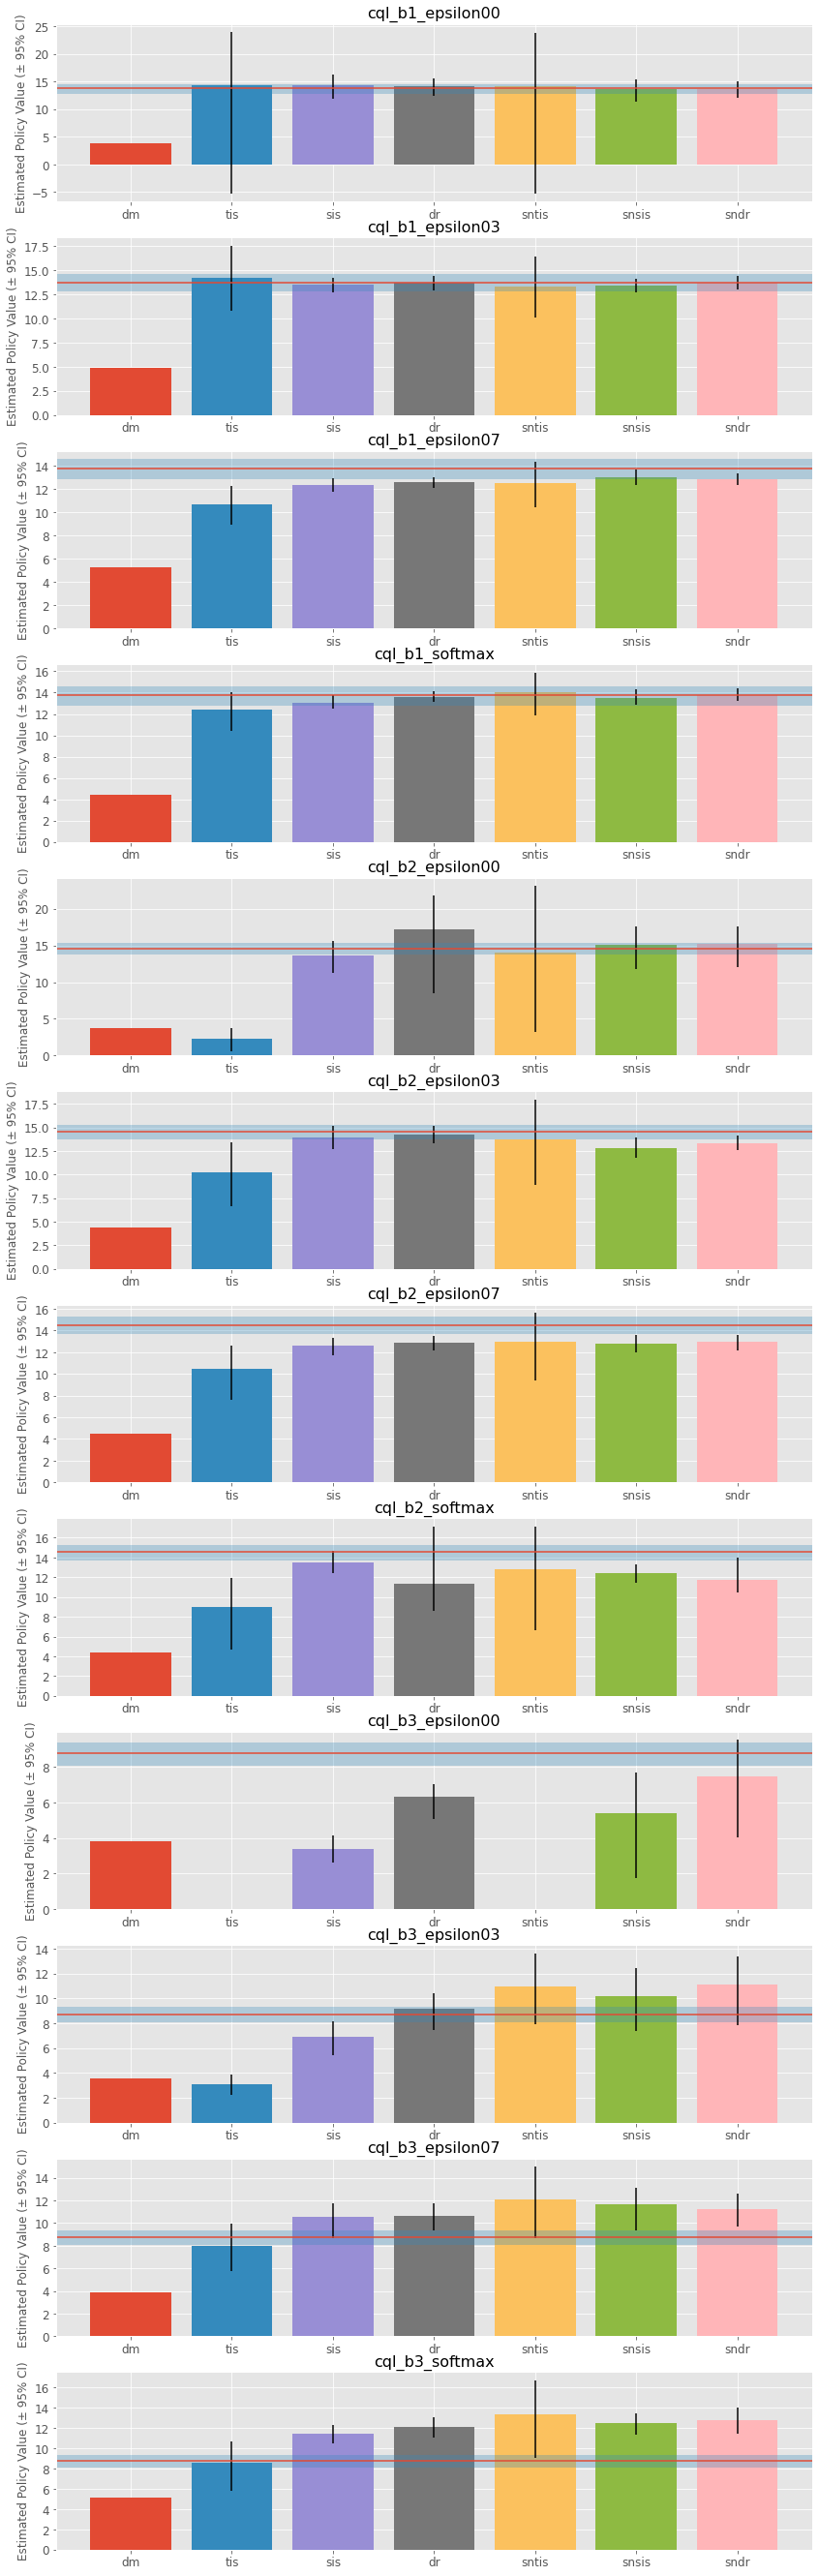

In [98]:
# visualize and compare the result
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, sharey=False)
# relative policy value to the behavior policy
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, sharey=False)

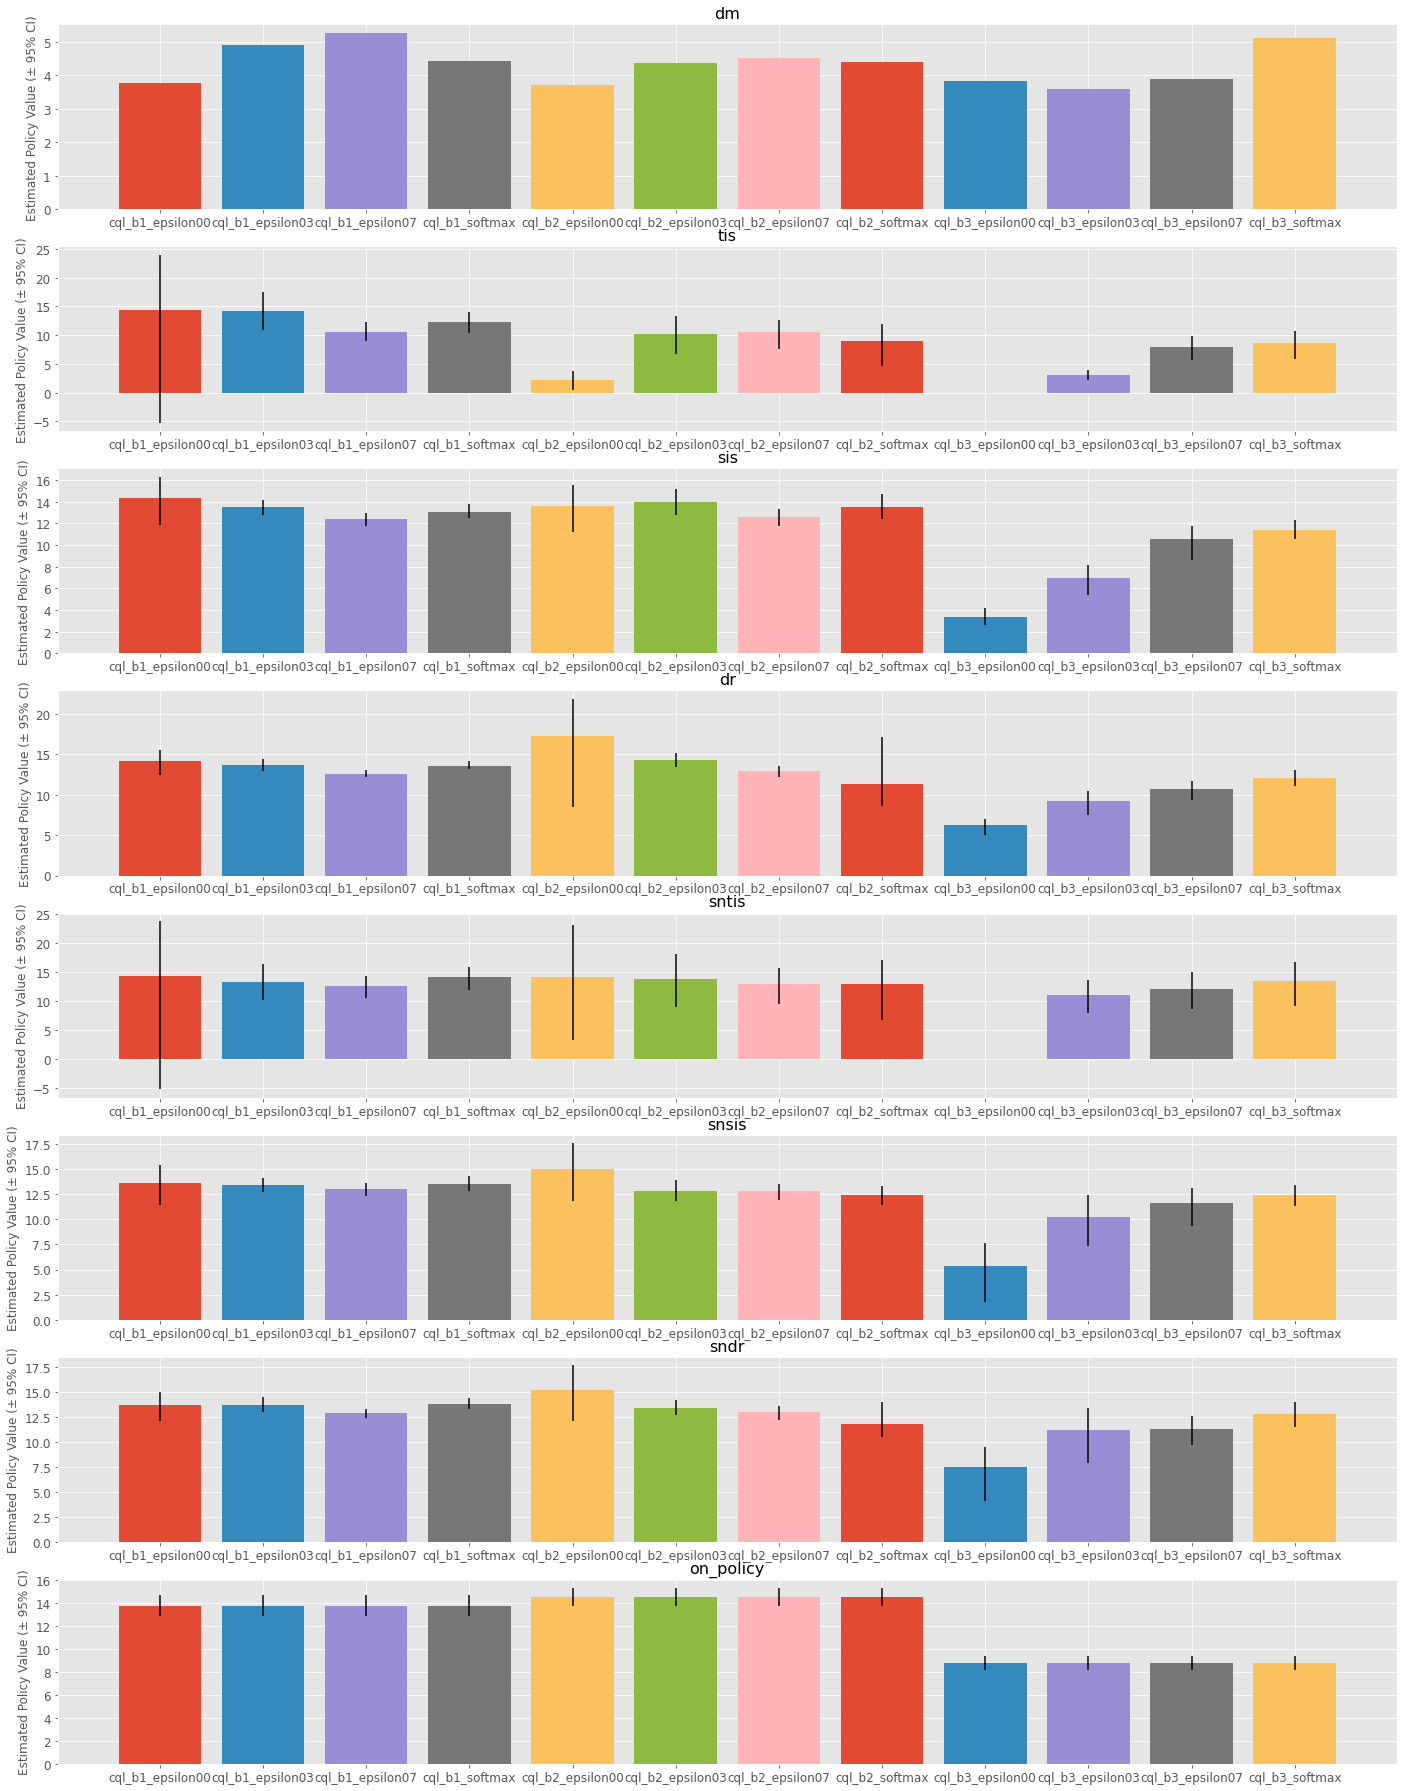

In [118]:
# we can also compare the policy value of candidate OPE estimators estimated by a single OPE estimator
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, hue="policy", sharey=False)
# relative policy value to the behavior policy
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, hue="policy", sharey=False)

#### Cumulative Distribution Function Estimation

We can also estimate various statistics of the policy performance based on the cumulative distribution function of the trajectory wise reward.

Specifically, we estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [102]:
from offlinegym.ope import DiscreteCumulativeDistributionalOffPolicyEvaluation as CumulativeDistributionalOPE
from offlinegym.ope import DiscreteCumulativeDistributionalDirectMethod as CD_DM
from offlinegym.ope import DiscreteCumulativeDistributionalImportanceSampling as CD_IS
from offlinegym.ope import DiscreteCumulativeDistributionalDoublyRobust as CD_DR
from offlinegym.ope import DiscreteCumulativeDistributionalSelfNormalizedImportanceSampling as CD_SNIS
from offlinegym.ope import DiscreteCumulativeDistributionalSelfNormalizedDoublyRobust as CD_SNDR

In [103]:
cd_ope = CumulativeDistributionalOPE(
    logged_dataset=logged_dataset,
    ope_estimators=[CD_DM(), CD_IS(), CD_DR(), CD_SNIS(), CD_SNDR()],
    use_observations_as_reward_scale=True,
)

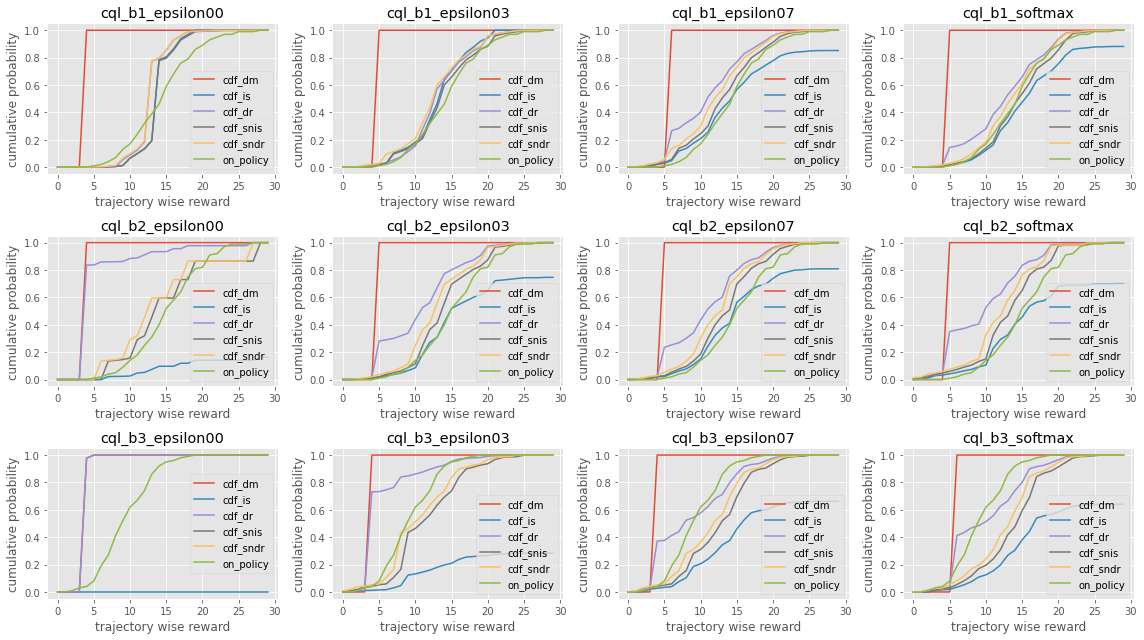

In [110]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function(input_dict, n_cols=4)

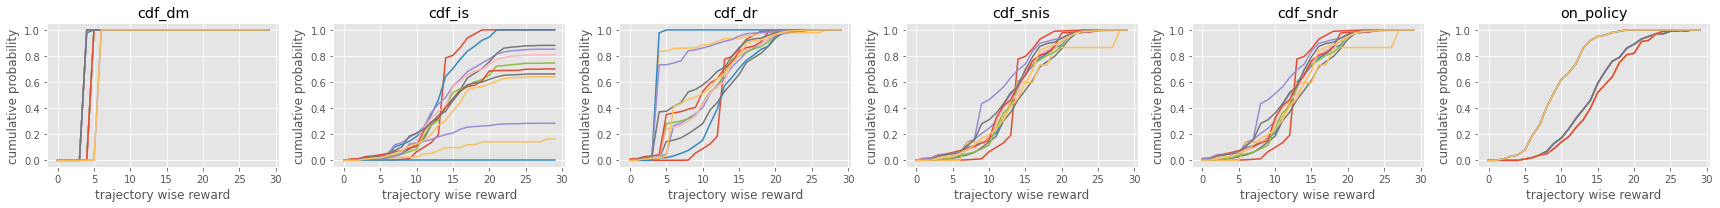

In [116]:
# cumulative distribution function comparison by each OPE estimator
# legend (evaluation policy name) is omitted here
cd_ope.visualize_cumulative_distribution_function(input_dict, hue="policy", n_cols=6, legend=False)

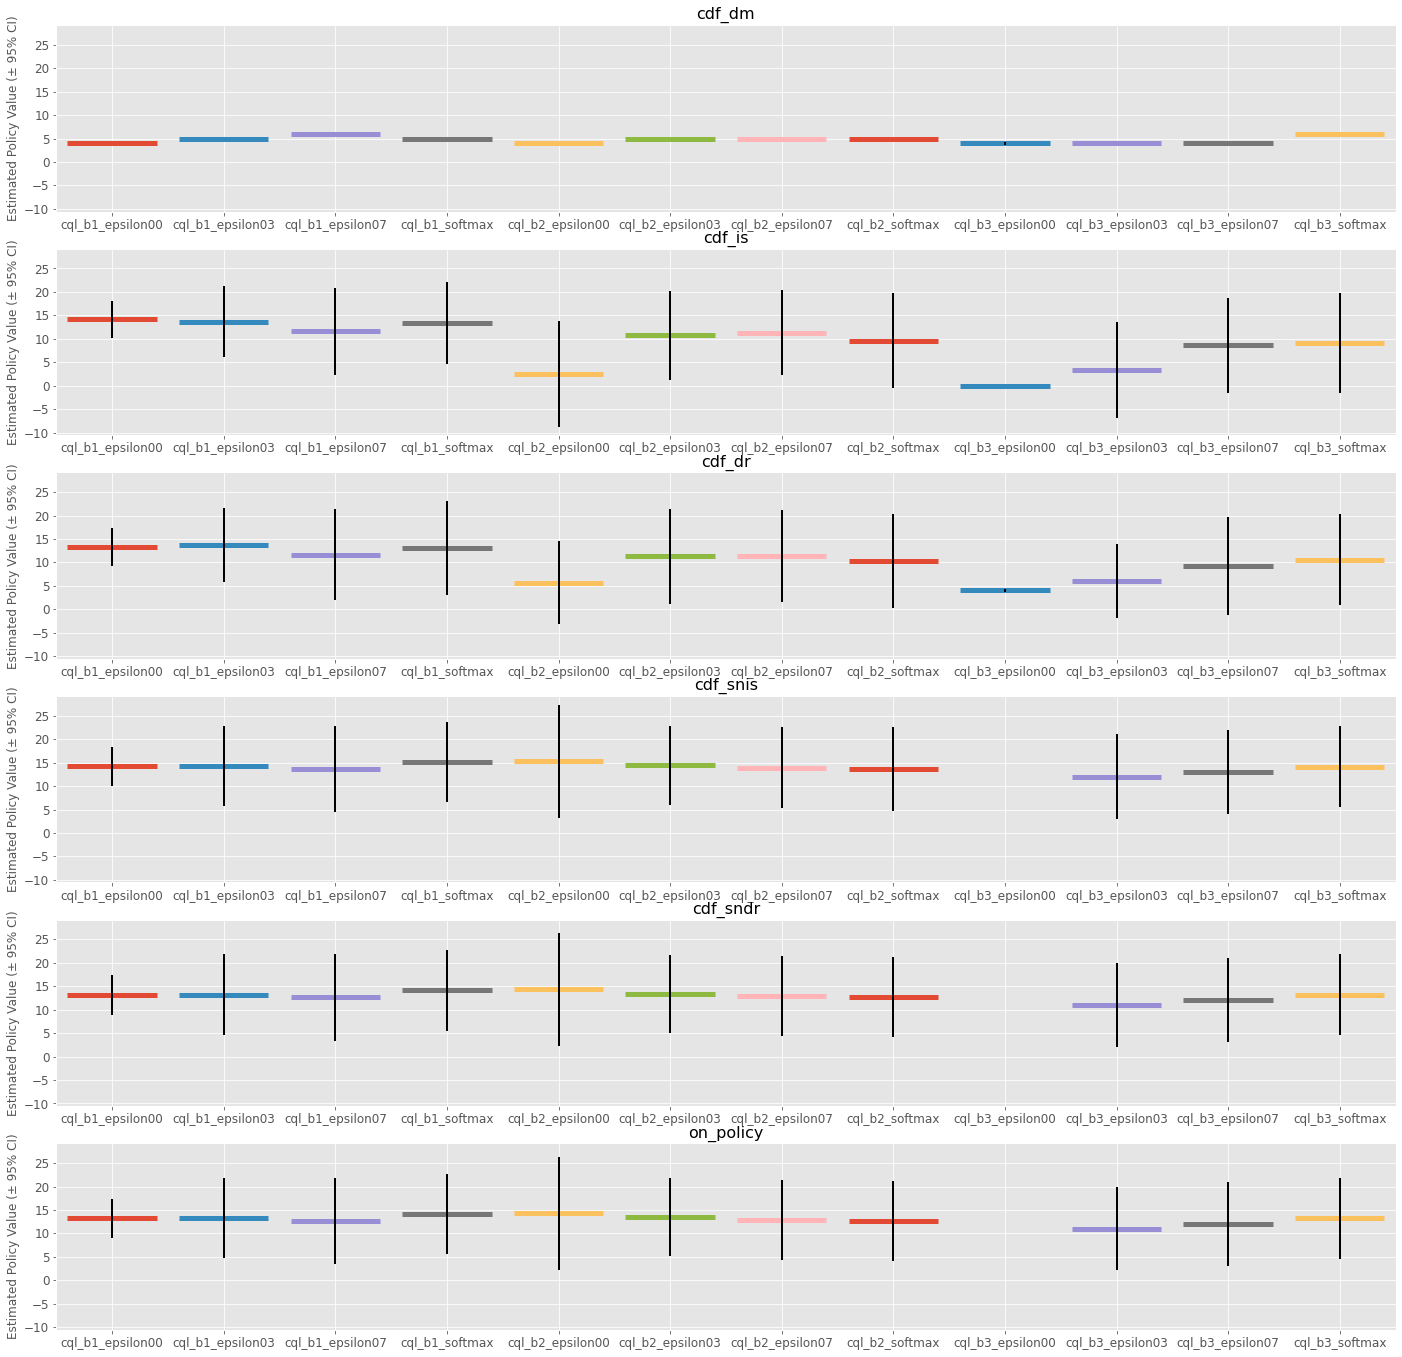

In [131]:
# policy value calculated from cumulative distrbution function
mean_dict = cd_ope.estimate_mean(input_dict)
variance_dict = cd_ope.estimate_variance(input_dict)
# visualize the policy value and its confidence intervals based on the mean and variance
# cd_ope.visualize_policy_value(input_dict, sharey=True)
# comparison among candidate policies by an OPE estimator
cd_ope.visualize_policy_value(input_dict, hue="policy", sharey=True)

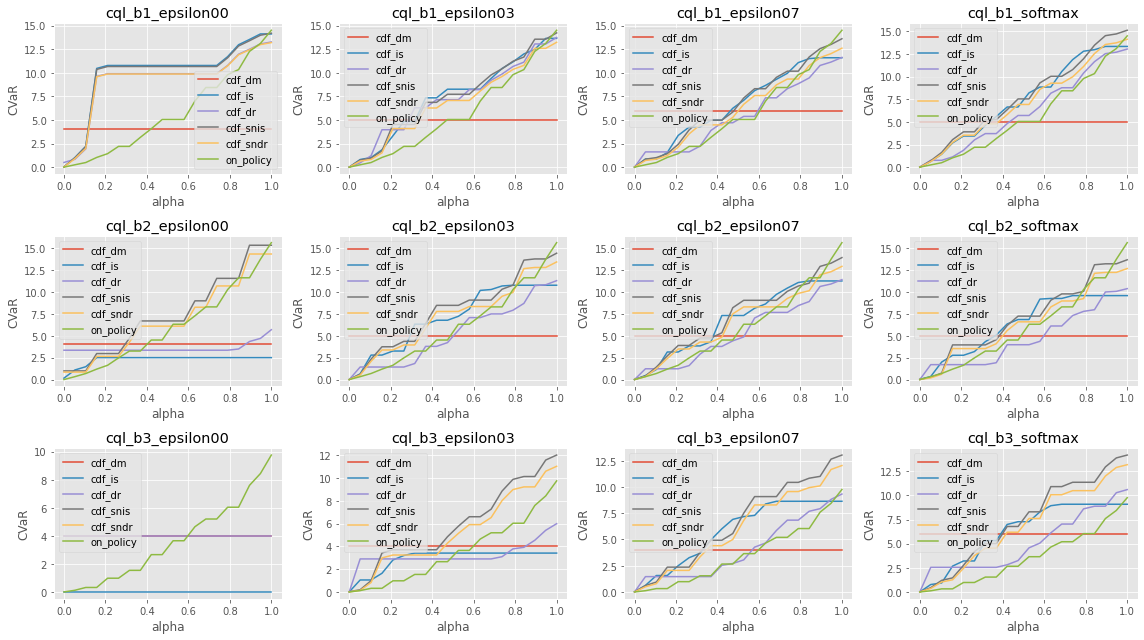

In [154]:
# conditional value at risk
cvar_dict = cd_ope.estimate_conditional_value_at_risk(input_dict, alphas=0.3)
# visualize conditional value at risk
cd_ope.visualize_conditional_value_at_risk(input_dict, alphas=np.linspace(0, 1, 20), n_cols=4, sharey=True)
# comparison among candidate policies by an OPE estimator
# cd_ope.visualize_conditional_value_at_risk(input_dict, alphas=np.linspace(0, 1, 20), n_cols=4, sharey=True)

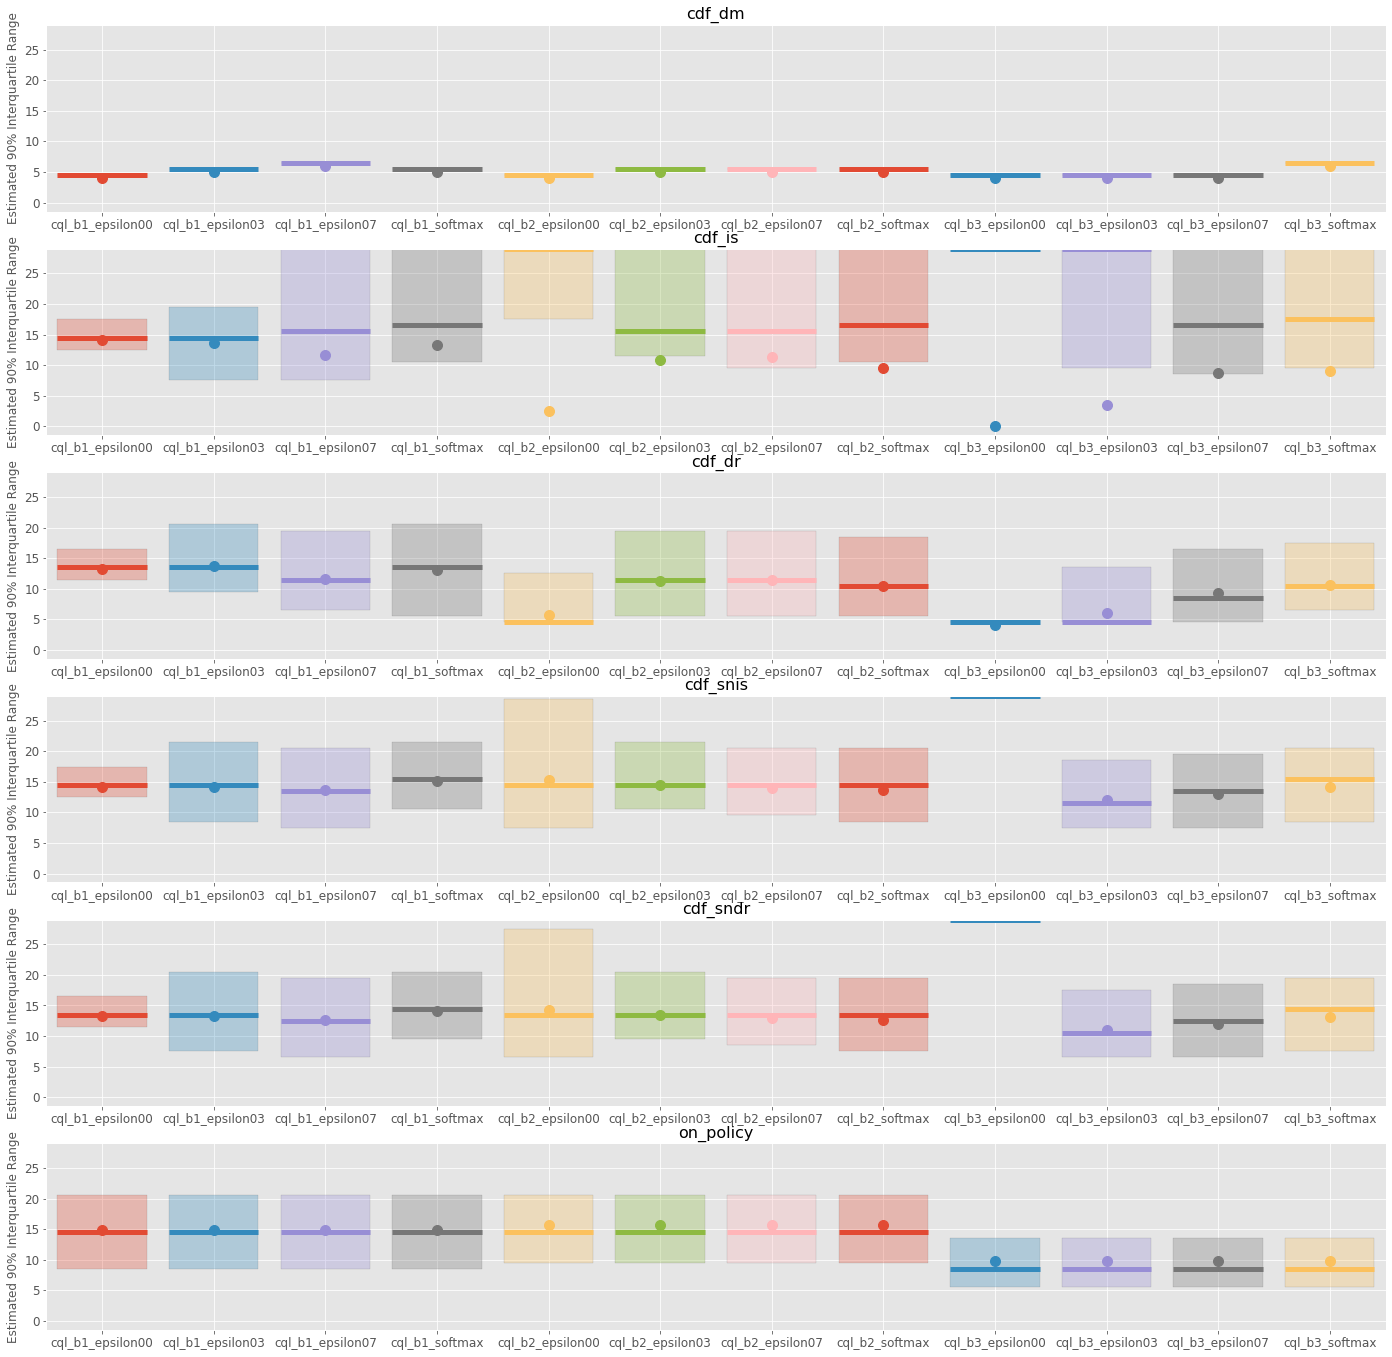

In [132]:
# interquartile range
interquartile_range_dict = cd_ope.estimate_interquartile_range(input_dict, alpha=0.10)
# visualize interquartile range
# cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, sharey=True)
# comparison among candidate policies by an OPE estimator
cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, hue="policy", sharey=True)

#### Distributionally Robust Policy Value Estimation

## Reference

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.